# 데이터셋 준비

In [1]:
!pip install pydicom

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMA이미지를 불러오는 라이브러리
import pydicom
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns
import torch.nn as nn

In [2]:
!pwd

/root


In [6]:
root = '/root'

In [7]:
# import glob
# import os
# import tarfile

# L_list = glob.glob(f"{root}/zip_folder/*")  # zip_folder 폴더 내 모든 L* 경로 가져오기

# for L_path in L_list:
#     # 압축 파일 경로 찾기 (*.tar.gz)
#     tar_files = glob.glob(f"{L_path}")

#     for file_path in tar_files:
#         folder_name = os.path.basename(file_path).split('_')[0]
#         extract_path = os.path.join(root, "mayo2016", folder_name)  # 압축 해제 경로 설정

#         # 압축 해제
#         with tarfile.open(file_path, "r:gz") as tar:
#             tar.extractall(path=extract_path)
#             print(f"✅ {file_path} → {extract_path} 압축 해제 완료!")

✅ /root/zip_folder/L333_quarter_1mm.tar.gz → /root/mayo2016/L333 압축 해제 완료!
✅ /root/zip_folder/L143_full_1mm.tar.gz → /root/mayo2016/L143 압축 해제 완료!
✅ /root/zip_folder/L192_quarter_1mm.tar.gz → /root/mayo2016/L192 압축 해제 완료!
✅ /root/zip_folder/L067_quarter_1mm.tar.gz → /root/mayo2016/L067 압축 해제 완료!
✅ /root/zip_folder/L291_quarter_1mm.tar.gz → /root/mayo2016/L291 압축 해제 완료!
✅ /root/zip_folder/L286_full_1mm.tar.gz → /root/mayo2016/L286 압축 해제 완료!
✅ /root/zip_folder/L333_full_1mm.tar.gz → /root/mayo2016/L333 압축 해제 완료!
✅ /root/zip_folder/L506_quarter_1mm.tar.gz → /root/mayo2016/L506 압축 해제 완료!
✅ /root/zip_folder/L286_quarter_1mm.tar.gz → /root/mayo2016/L286 압축 해제 완료!
✅ /root/zip_folder/L096_full_1mm.tar.gz → /root/mayo2016/L096 압축 해제 완료!
✅ /root/zip_folder/L506_full_1mm.tar.gz → /root/mayo2016/L506 압축 해제 완료!
✅ /root/zip_folder/L310_quarter_1mm.tar.gz → /root/mayo2016/L310 압축 해제 완료!
✅ /root/zip_folder/L096_quarter_1mm.tar.gz → /root/mayo2016/L096 압축 해제 완료!
✅ /root/zip_folder/L109_full_1mm.tar.gz 

In [10]:
import glob

L_list = glob.glob(f'{root}/mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list, len(L_list)

(['L067',
  'L096',
  'L109',
  'L143',
  'L192',
  'L286',
  'L291',
  'L310',
  'L333',
  'L506'],
 10)

In [11]:
data_label = ['quarter_1mm', 'full_1mm']

In [12]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [13]:
def extract_patches(img, patch_size=55, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55, numpy

In [14]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []

    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [15]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches

In [16]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

In [17]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir
            y_dir_list += y_dir

        for X_dir, y_dir in tqdm(zip(X_dir_list, y_dir_list), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            for i in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[i]), torch.from_numpy(y_patches[i]) # torch로 넣어주자.
                self.image_pairs.append((X_patch, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)

        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = self.image_pairs[idx][0]
        y = self.image_pairs[idx][1]
        return X, y

In [ ]:
# train_dataset = CustomDataset('train',patch_maker_W_aug,L_list)
# val_dataset = CustomDataset('val',patch_maker_WO_aug,L_list)
# test_dataset = CustomDataset('test',patch_maker_WO_aug,L_list)

test is processing: 100%|██████████| 1190/1190 [00:04<00:00, 267.37it/s]


In [19]:
# 파일 경로 설정

folder_name = f'{root}/dataset/'
train_path = folder_name+'train_dataset.pt'
val_path = folder_name+'val_dataset.pt'
test_path = folder_name+'test_dataset.pt'

In [ ]:
# # 데이터셋 저장
# torch.save(train_dataset, train_path)
# torch.save(val_dataset, val_path)
# torch.save(test_dataset, test_path)

In [23]:
# 데이터셋 불러오기
train_dataset = torch.load(train_path) # , weights_only=False
val_dataset = torch.load(val_path)
test_dataset = torch.load(test_path)

In [24]:
batch_size = 16
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [25]:
len(train_loader), len(val_loader), len(test_loader)

(57701, 4815, 6025)

# attention모델1 (SEBlock); Channel Attention

In [26]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
        self.last_attention = None  # 저장된 Attention 값을 위한 변수

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # 채널별 전역 평균 풀링
        y = self.avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        self.last_attention = y  # 계산된 Attention Weight 저장
        return x * y


In [ ]:
# class SEBlock(nn.Module):
#     def __init__(self, in_channels, reduction=16):
#         super(SEBlock, self).__init__()
#         self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # 채널별로 matrix(가로x세로)의 평균을 계산한다.
#         self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)  # 축소
#         self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)  # 복원
#         self.sigmoid = nn.Sigmoid()  # 가중치 계산

#     def forward(self, x):
#         batch, channels, _, _ = x.size()
#         y = self.global_avg_pool(x).view(batch, channels)  # 채널별 압축
#         y = self.fc1(y)
#         y = nn.ReLU()(y)
#         y = self.fc2(y)
#         y = self.sigmoid(y).view(batch, channels, 1, 1)  # 가중치를 입력 텐서 크기로 복원
#         return x * y  # 채널별로 가중치 적용

## SEBlock 살펴보기

In [ ]:
X_train, y_train = next(iter(train_loader))

conv_layer = nn.Conv2d(1, 96, 5, 1, 0)
conv_x = conv_layer(X_train)

se1 = SEBlock(96)
se_x = se1(conv_x)

X_train.shape, conv_layer(X_train).shape, se_x.shape

(torch.Size([16, 1, 55, 55]),
 torch.Size([16, 96, 51, 51]),
 torch.Size([16, 96, 51, 51]))

#### 1. channel 마다 avgpool

In [ ]:
global_avg_pool = nn.AdaptiveAvgPool2d(1) # channel마다 feature-map의 값을 하나의 mean값으로 만든다.
global_avg_pool(X_train).shape

torch.Size([16, 1, 1, 1])

In [ ]:
batch, channels, _, _ = X_train.size()
global_avg_pool(X_train).view(batch, channels).shape

torch.Size([16, 1])

In [ ]:
tensor = torch.tensor([
    [[1, 1], [1, 1]],  # 첫 번째 채널
    [[2, 2], [2, 2]],  # 두 번째 채널
    [[3, 3], [3, 3]]   # 세 번째 채널
], dtype=torch.float32)

tensor

tensor([[[1., 1.],
         [1., 1.]],

        [[2., 2.],
         [2., 2.]],

        [[3., 3.],
         [3., 3.]]])

In [ ]:
# 배치 차원을 추가 (모델 입력 형태로 만들기 위해)
tensor = tensor.unsqueeze(0)
tensor.shape

torch.Size([1, 3, 2, 2])

In [ ]:
global_avg_pool(tensor), global_avg_pool(tensor).shape

(tensor([[[[1.]],
 
          [[2.]],
 
          [[3.]]]]),
 torch.Size([1, 3, 1, 1]))

In [ ]:
batch, channels, _, _ = global_avg_pool(tensor).size()
global_avg_pool(global_avg_pool(tensor)).view(batch, channels).shape

torch.Size([1, 3])

In [ ]:
global_avg_pool(global_avg_pool(tensor)).view(batch, channels)

tensor([[1., 2., 3.]])

#### 2. auto-encoder 구조로 압축했다 늘리기

In [ ]:
conv_layer = nn.Conv2d(1, 96, 5, 1, 0)
conv_x = conv_layer(X_train)
batch, channels, _, _ = conv_x.size()
y = global_avg_pool(conv_x).view(batch, channels)

in_channels = 96
reduction = 16
fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)  # 축소
fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)  # 복원

print(y.shape)
y = fc1(y) # 중간에 6으로 축소
print(y.shape)
y = nn.ReLU()(y)
y = fc2(y)
print(y.shape) # 다시 96으로 늘리기

torch.Size([16, 96])
torch.Size([16, 6])
torch.Size([16, 96])


#### 3. sigmoid로 0~1 사이값으로 만들어서, 가중치로 실제값에 곱하기

In [ ]:
sigmoid = nn.Sigmoid()  # 가중치 계산
y = sigmoid(y).view(batch, channels, 1, 1)  # 가중치를 입력 텐서 크기로 복원

y.shape, y.max(), y.min()

(torch.Size([16, 96, 1, 1]),
 tensor(0.6523, grad_fn=<MaxBackward1>),
 tensor(0.3745, grad_fn=<MinBackward1>))

In [ ]:
(conv_x * y).shape

torch.Size([16, 96, 51, 51])

## 모델구현

2개의 attention을 앞단의 중간과 마지막 부분에 각각 설치

In [27]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [28]:
class RedCNNWithChannelAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithChannelAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Attention Blocks (효율적 배치)
        self.attention2 = SEBlock(96)  # 중간 계층
        self.attention3 = SEBlock(96)  # 고수준 특징 계층

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.attention2(x)  # 중간 계층에 Attention
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.attention3(x)  # 최종 인코더 계층에 Attention

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [29]:
model = RedCNNWithChannelAttention().to(device)
model

RedCNNWithChannelAttention(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (attention2): SEBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=96, out_features=6, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=6, out_features=96, bias=False)
      (3): Sigmoid()
    )
  )
  (attention3): SEBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=96, out_features=6, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=6, out_features=96, bias=False)
      (3): Sigmoid()
    )
  )
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 9

In [30]:
%cd /root/

import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

/root


<module 'utils.train_eval_util' from '/root/utils/train_eval_util.py'>

In [31]:
import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

In [32]:
import torch
from tqdm import tqdm

interval = 1000

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0.0  # ✅ 초기화

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item() * X.size(0)  # ✅ 배치별 손실 계산
        total_loss += batch_loss  # ✅ 모든 배치 손실 누적
        running_loss += batch_loss  # interval 내 손실 누적

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)  # ✅ 평균 손실 반환

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0.0  # ✅ 초기화

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            batch_loss = loss.item() * X.size(0)  # ✅ 배치별 손실 계산
            total_loss += batch_loss  # ✅ 모든 배치 손실 누적
            running_loss += batch_loss  # interval 내 손실 누적

            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                running_loss = 0.0
                tqdm.write(f'val loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)  # ✅ 평균 손실 반환


# 학습

In [33]:
!pwd

/root


In [34]:
%cd {root}/attention_channel

/root/attention_channel


In [ ]:
epochs = 1
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + 'red_cnn_C_A' + ".pth")
    if (early_stopping(valid_loss)):
        break

Epoch 0 - Training:   2%|▏         | 1017/57701 [00:13<09:44, 96.90it/s]

train loss : 0.08059280084446073


Epoch 0 - Training:   3%|▎         | 2011/57701 [00:23<10:00, 92.76it/s] 

train loss : 0.058686302971094846


Epoch 0 - Training:   5%|▌         | 3014/57701 [00:34<09:51, 92.47it/s] 

train loss : 0.053694813266396524


Epoch 0 - Training:   7%|▋         | 4015/57701 [00:44<09:29, 94.32it/s] 

train loss : 0.051111514257267114


Epoch 0 - Training:   9%|▊         | 5015/57701 [00:55<09:15, 94.79it/s] 

train loss : 0.04959829536639154


Epoch 0 - Training:  10%|█         | 6018/57701 [01:05<08:42, 98.86it/s] 

train loss : 0.04769635261781514


Epoch 0 - Training:  12%|█▏        | 7015/57701 [01:15<09:13, 91.50it/s] 

train loss : 0.04707402632199228


Epoch 0 - Training:  14%|█▍        | 8019/57701 [01:26<08:32, 96.99it/s] 

train loss : 0.04563572202809155


Epoch 0 - Training:  16%|█▌        | 9012/57701 [01:36<08:30, 95.30it/s] 

train loss : 0.04540889086946845


Epoch 0 - Training:  17%|█▋        | 10011/57701 [01:47<08:07, 97.90it/s]

train loss : 0.04389173284173012


Epoch 0 - Training:  19%|█▉        | 11006/57701 [01:57<08:25, 92.41it/s] 

train loss : 0.044092745082452894


Epoch 0 - Training:  21%|██        | 12013/57701 [02:08<07:44, 98.41it/s] 

train loss : 0.043785513890907166


Epoch 0 - Training:  23%|██▎       | 13017/57701 [02:18<07:56, 93.84it/s] 

train loss : 0.04274249910004437


Epoch 0 - Training:  24%|██▍       | 14012/57701 [02:28<07:43, 94.26it/s] 

train loss : 0.042401206290349366


Epoch 0 - Training:  26%|██▌       | 15016/57701 [02:39<07:30, 94.85it/s] 

train loss : 0.04197303348965943


Epoch 0 - Training:  28%|██▊       | 16011/57701 [02:49<07:19, 94.93it/s] 

train loss : 0.041933650137856604


Epoch 0 - Training:  29%|██▉       | 17020/57701 [03:00<06:48, 99.68it/s] 

train loss : 0.04092549774795771


Epoch 0 - Training:  31%|███       | 18014/57701 [03:10<06:52, 96.30it/s] 

train loss : 0.041625152092427016


Epoch 0 - Training:  33%|███▎      | 19010/57701 [03:20<06:46, 95.16it/s] 

train loss : 0.04121506755240262


Epoch 0 - Training:  35%|███▍      | 20015/57701 [03:31<06:31, 96.35it/s] 

train loss : 0.04064959459379315


Epoch 0 - Training:  36%|███▋      | 21017/57701 [03:41<06:28, 94.41it/s] 

train loss : 0.04020898940041661


Epoch 0 - Training:  38%|███▊      | 22010/57701 [03:51<06:27, 92.20it/s] 

train loss : 0.03979042611829937


Epoch 0 - Training:  40%|███▉      | 23010/57701 [04:02<06:14, 92.65it/s] 

train loss : 0.04021508434973657


Epoch 0 - Training:  42%|████▏     | 24010/57701 [04:13<05:57, 94.33it/s] 

train loss : 0.04014316881820559


Epoch 0 - Training:  43%|████▎     | 25018/57701 [04:23<05:23, 100.94it/s]

train loss : 0.03954565378092229


Epoch 0 - Training:  45%|████▌     | 26016/57701 [04:37<05:24, 97.50it/s] 

train loss : 0.03998942530155182


Epoch 0 - Training:  47%|████▋     | 27015/57701 [04:53<05:27, 93.73it/s] 

train loss : 0.0393099065348506


Epoch 0 - Training:  49%|████▊     | 28008/57701 [05:03<05:36, 88.35it/s] 

train loss : 0.03906719692610204


Epoch 0 - Training:  50%|█████     | 29015/57701 [05:13<05:00, 95.41it/s] 

train loss : 0.03935767462104559


Epoch 0 - Training:  52%|█████▏    | 30010/57701 [05:24<04:55, 93.58it/s] 

train loss : 0.039235882114619015


Epoch 0 - Training:  54%|█████▎    | 31013/57701 [05:34<04:48, 92.59it/s] 

train loss : 0.03919272841140628


Epoch 0 - Training:  55%|█████▌    | 32008/57701 [05:44<04:47, 89.47it/s] 

train loss : 0.038214227410033344


Epoch 0 - Training:  57%|█████▋    | 33020/57701 [05:55<04:12, 97.70it/s] 

train loss : 0.03859714315645397


Epoch 0 - Training:  59%|█████▉    | 34009/57701 [06:06<04:11, 94.39it/s] 

train loss : 0.038366714527830484


Epoch 0 - Training:  61%|██████    | 35016/57701 [06:16<03:57, 95.39it/s]

train loss : 0.038668623931705955


Epoch 0 - Training:  62%|██████▏   | 36013/57701 [06:27<03:45, 96.39it/s] 

train loss : 0.03822797645814717


Epoch 0 - Training:  64%|██████▍   | 37018/57701 [06:37<03:42, 93.12it/s] 

train loss : 0.038879077734425664


Epoch 0 - Training:  66%|██████▌   | 38017/57701 [06:47<03:29, 93.92it/s] 

train loss : 0.03810578441992402


Epoch 0 - Training:  68%|██████▊   | 39016/57701 [06:58<03:09, 98.56it/s] 

train loss : 0.03781754300557077


Epoch 0 - Training:  69%|██████▉   | 40017/57701 [07:08<03:04, 96.05it/s] 

train loss : 0.037557501586154105


Epoch 0 - Training:  71%|███████   | 41013/57701 [07:19<02:39, 104.88it/s]

train loss : 0.038440338220447304


Epoch 0 - Training:  73%|███████▎  | 42011/57701 [07:29<02:42, 96.71it/s] 

train loss : 0.03757801622711122


Epoch 0 - Training:  75%|███████▍  | 43015/57701 [07:39<02:35, 94.20it/s] 

train loss : 0.03721925649978221


Epoch 0 - Training:  76%|███████▋  | 44018/57701 [07:49<02:25, 94.29it/s] 

train loss : 0.03735023925453424


Epoch 0 - Training:  78%|███████▊  | 45011/57701 [07:59<02:13, 95.27it/s] 

train loss : 0.03779520066641271


Epoch 0 - Training:  80%|███████▉  | 46015/57701 [08:10<02:06, 92.70it/s] 

train loss : 0.03822830954752862


Epoch 0 - Training:  81%|████████▏ | 47012/57701 [08:22<02:00, 89.06it/s] 

train loss : 0.03732661446742713


Epoch 0 - Training:  83%|████████▎ | 48014/57701 [08:33<01:42, 94.34it/s] 

train loss : 0.037690567215904594


Epoch 0 - Training:  85%|████████▍ | 49012/57701 [08:43<01:27, 99.05it/s] 

train loss : 0.03706765899434686


Epoch 0 - Training:  87%|████████▋ | 50015/57701 [08:54<01:19, 96.72it/s] 

train loss : 0.03720338955335319


Epoch 0 - Training:  88%|████████▊ | 51014/57701 [09:04<01:08, 97.54it/s] 

train loss : 0.0374483987595886


Epoch 0 - Training:  90%|█████████ | 52015/57701 [09:15<01:01, 92.93it/s] 

train loss : 0.03733348546735942


Epoch 0 - Training:  92%|█████████▏| 53010/57701 [09:25<00:48, 96.23it/s] 

train loss : 0.03684339767880738


Epoch 0 - Training:  94%|█████████▎| 54016/57701 [09:36<00:39, 93.74it/s] 

train loss : 0.03692296765558421


Epoch 0 - Training:  95%|█████████▌| 55013/57701 [09:46<00:28, 93.11it/s] 

train loss : 0.036955458329990504


Epoch 0 - Training:  97%|█████████▋| 56012/57701 [09:57<00:17, 94.64it/s] 

train loss : 0.03734747694619


Epoch 0 - Training:  99%|█████████▉| 57014/57701 [10:07<00:07, 94.20it/s] 

train loss : 0.037330944865942


Epoch 0 - Evaluating:  22%|██▏       | 1059/4815 [00:05<00:11, 332.37it/s]

val loss : 0.043553308488801123


Epoch 0 - Evaluating:  42%|████▏     | 2044/4815 [00:07<00:07, 346.51it/s]

val loss : 0.046788724801503125


Epoch 0 - Evaluating:  63%|██████▎   | 3035/4815 [00:10<00:05, 347.34it/s]

val loss : 0.03123810607427731


Epoch 0 - Evaluating:  84%|████████▍ | 4050/4815 [00:13<00:02, 311.94it/s]

val loss : 0.03458818422816694


Epoch 0 - Evaluating: 100%|██████████| 4815/4815 [00:16<00:00, 289.43it/s]

Epoch [1/1], Train Loss: 0.0026, Valid Loss: 0.0023



/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [36]:
import pickle

data_to_save = {
    'train_loss_per_iter': train_loss_per_iter,
    'val_loss_per_iter': val_loss_per_iter,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch
}

for filename, data in data_to_save.items():
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [37]:
import pickle

filenames = [
    'train_loss_per_iter.pkl',
    'val_loss_per_iter.pkl',
    'train_loss_per_epoch.pkl',
    'val_loss_per_epoch.pkl'
]

variables = [
    'train_loss_per_iter',
    'val_loss_per_iter',
    'train_loss_per_epoch',
    'val_loss_per_epoch'
]

data_to_load = dict(zip(filenames, variables))

for filename, variable_name in data_to_load.items():
    with open(filename, 'rb') as f:
        globals()[variable_name] = pickle.load(f)

In [38]:
train_flatten, val_flatten = [item for sublist in train_loss_per_iter for item in sublist], [item for sublist in val_loss_per_iter for item in sublist]

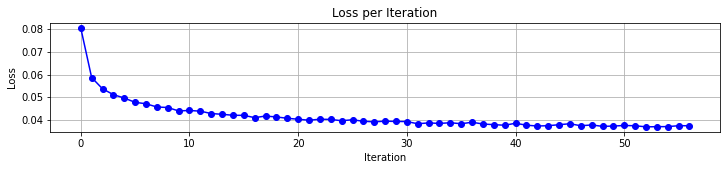

In [39]:
plt.figure(figsize=(12, 2))

# 반복 단위 손실 그래프
plt.plot(train_flatten, label='Train (per iter)', linestyle='-', marker='o', color='blue')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

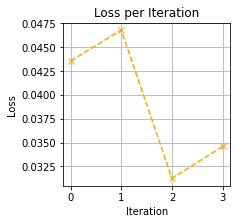

In [40]:
plt.plot(val_flatten, label='Validation (per iter)', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

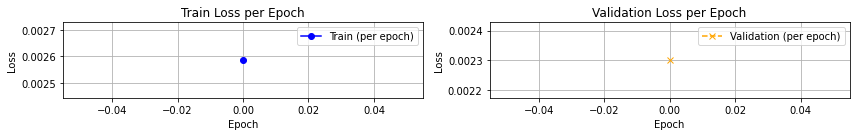

In [41]:
# 1행 2열 레이아웃 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 2))  # 그래프 크기 조정

# Train loss per epoch 그래프
axes[0].plot(train_loss_per_epoch, label='Train (per epoch)', linestyle='-', marker='o', color='blue')
axes[0].set_title("Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# Validation loss per epoch 그래프
axes[1].plot(val_loss_per_epoch, label='Validation (per epoch)', linestyle='--', marker='x', color='orange')
axes[1].set_title("Validation Loss per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

# 평가

In [42]:
!pwd

/root/attention_channel


In [43]:
%cd {root}/attention_channel

/root/attention_channel


In [44]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## batch size 16

### loss 추이 관찰

In [45]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithChannelAttention().to(device)
model.load_state_dict(torch.load('red_cnn_C_A.pth'))

<All keys matched successfully>

In [46]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

6025

In [47]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  18%|█▊        | 1063/6025 [00:03<00:14, 342.24it/s]

train loss : 0.03816002911934629


Evaluating:  34%|███▍      | 2045/6025 [00:05<00:11, 337.62it/s]

train loss : 0.03506631569843739


Evaluating:  51%|█████     | 3049/6025 [00:08<00:08, 343.87it/s]

train loss : 0.03668037666985765


Evaluating:  67%|██████▋   | 4053/6025 [00:11<00:06, 323.79it/s]

train loss : 0.026031348993536086


Evaluating:  84%|████████▍ | 5046/6025 [00:14<00:02, 348.32it/s]

train loss : 0.025453931195195765


Evaluating: 100%|█████████▉| 6022/6025 [00:17<00:00, 339.46it/s]

train loss : 0.023492591925431044


Evaluating: 100%|██████████| 6025/6025 [00:18<00:00, 330.15it/s]


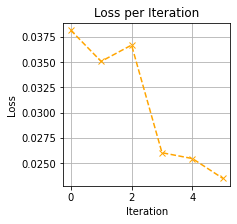

In [48]:
plt.plot(loss_list, label='Test', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

### 16개 개별비교

In [49]:
def visualize_patches_total(X, y, X_hat):

    fig, axes = plt.subplots(3, 16, figsize=(32, 6))  # 3행 16열로 설정
    fig.suptitle("Patches", fontsize=12, y=1.05)  # 전체 제목 추가

    for i in range(X.shape[0]):  # 16개의 이미지만큼 반복
        # X 데이터 시각화
        axes[0, i].imshow(X[i], cmap='gray', vmin=-200, vmax=300)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"X {i+1}", fontsize=12)

        # y 데이터 시각화
        axes[1, i].imshow(y[i], cmap='gray', vmin=-200, vmax=300)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"y {i+1}", fontsize=12)

        # X_hat 데이터 시각화
        axes[2, i].imshow(X_hat[i], cmap='gray', vmin=-200, vmax=300)
        axes[2, i].axis('off')
        axes[2, i].set_title(f"X_hat {i+1}", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # 제목 위치 조정
    plt.show()


In [50]:
# 1. 랜덤비교

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_iter = iter(test_loader)
len(test_iter)

6025

In [51]:
idx = 400 # 1~6025 여기 안에서 선택
for i in range(idx):
    X_test, y_test = next(test_iter)

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(model(X_test.cuda()).cpu().detach()).numpy() * 500 - 500

In [52]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

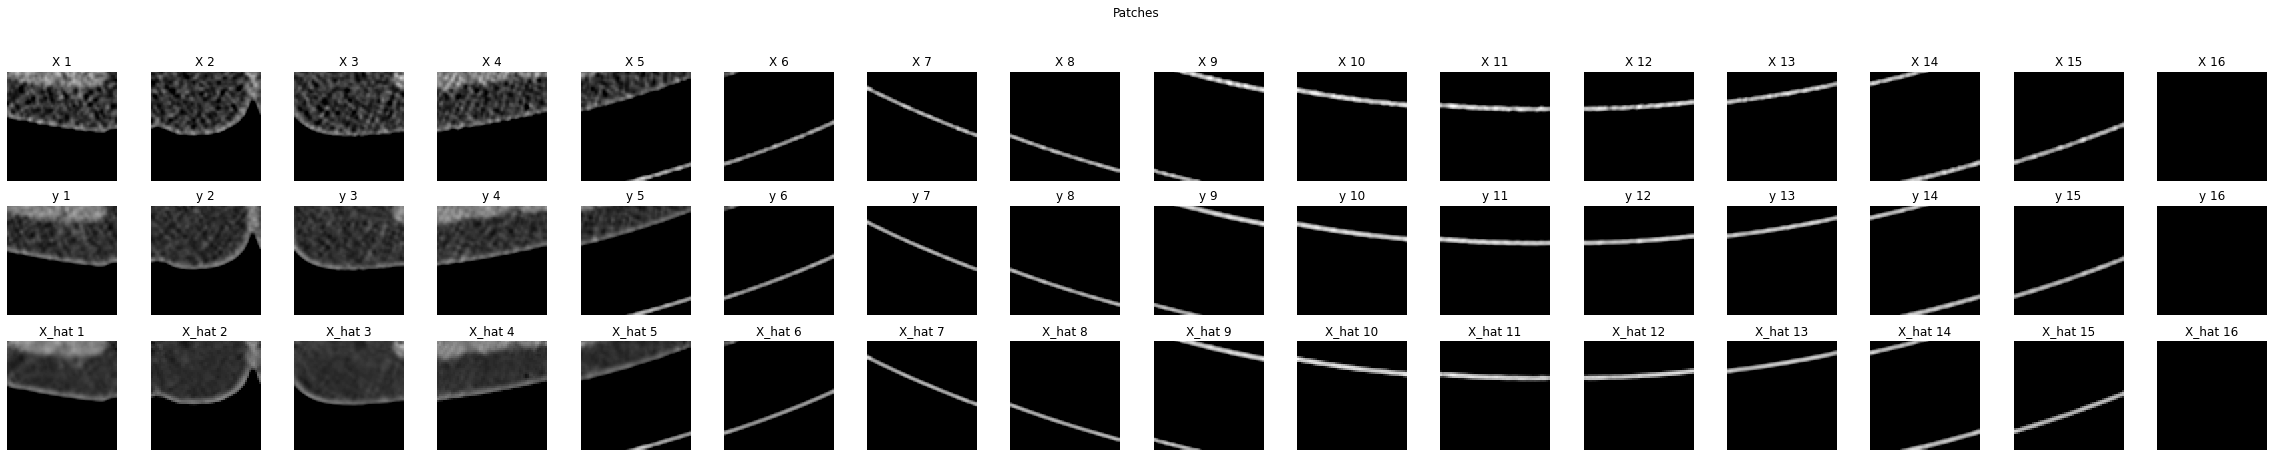

In [53]:
visualize_patches_total(X, y, X_hat)

In [54]:
# 2. 가장 loss가 낮은 값 확인

X_test,y_test,X_hat = best

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(X_hat.cpu().numpy()) * 500 - 500

In [55]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

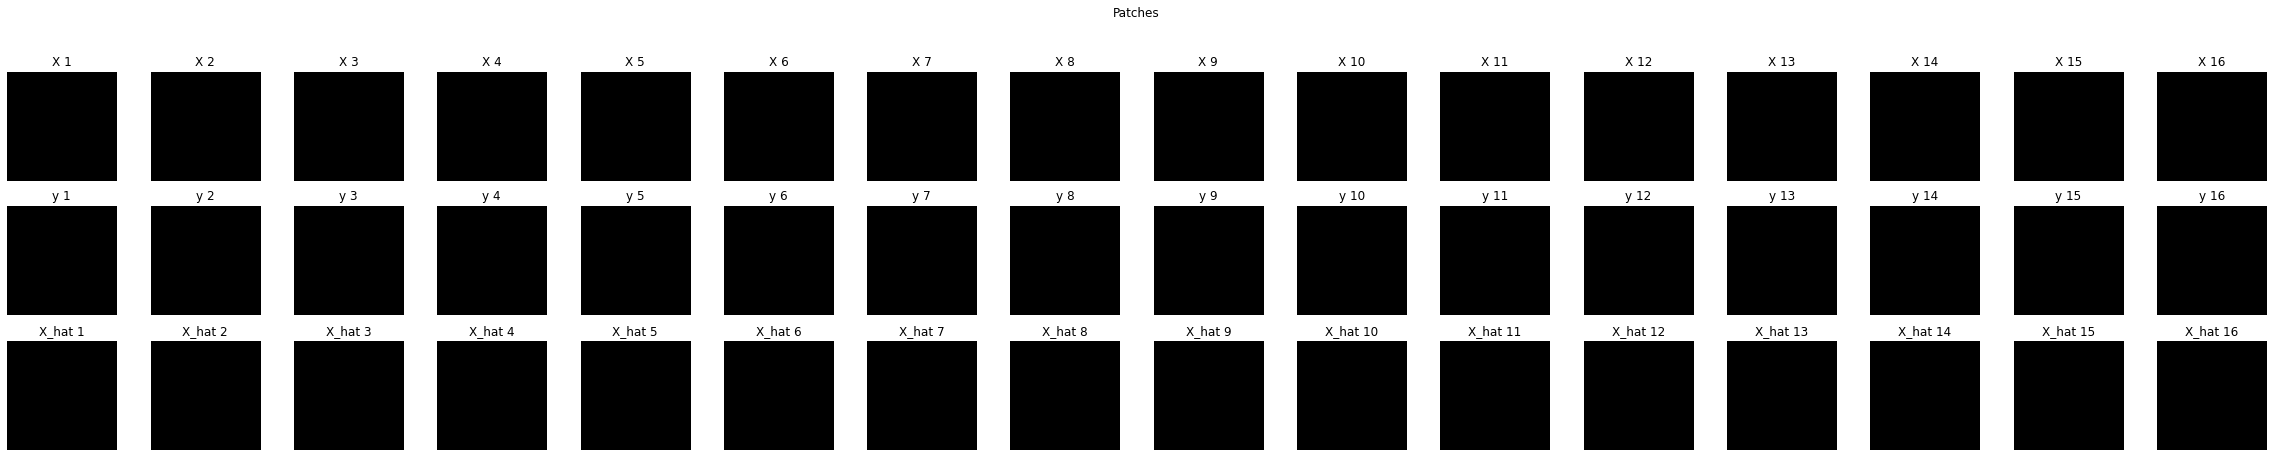

In [56]:
visualize_patches_total(X, y, X_hat)

In [57]:
# 3. 가장 loss가 높은 값 확인

X_test,y_test,X_hat = worst

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(X_hat.cpu().numpy()) * 500 - 500

In [58]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

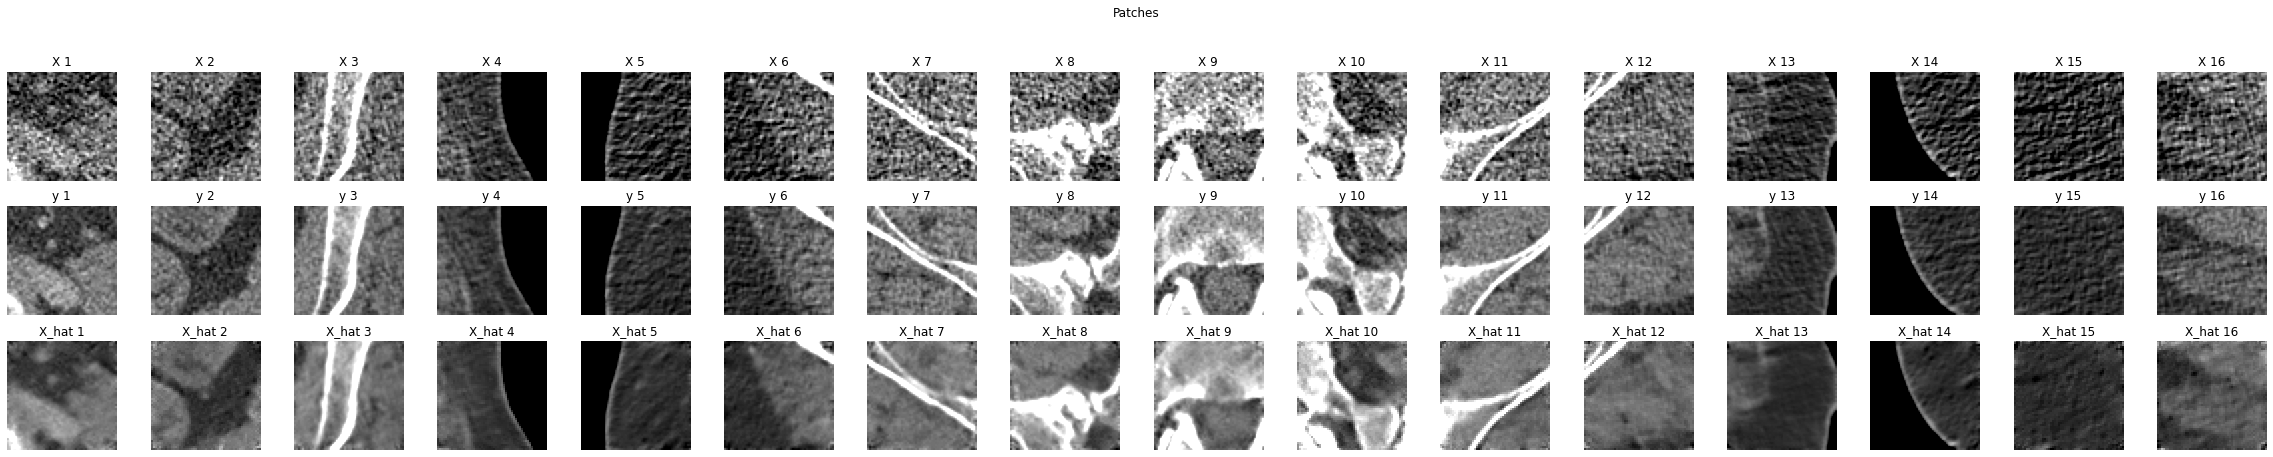

In [59]:
visualize_patches_total(X, y, X_hat)

## batch size = 81

In [60]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithChannelAttention().to(device)
model.load_state_dict(torch.load('red_cnn_C_A.pth'))

<All keys matched successfully>

In [61]:
test_loader = DataLoader(test_dataset, batch_size=81, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

1190

In [62]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  85%|████████▌ | 1013/1190 [00:15<00:02, 65.40it/s]

train loss : 0.1632083263612585


Evaluating: 100%|██████████| 1190/1190 [00:18<00:00, 63.34it/s]


### 함수정의

In [63]:
def reconstruct_image(prediction, num_patches_per_row=9, patch_size=55):
    # prediction: (81, 1, 55, 55) 크기의 torch 텐서
    num_patches = prediction.shape[0]  # 81개의 패치
    assert prediction.shape == (81, 1, 55, 55) # "패치의 크기가 올바르지 않습니다."

    # 최종적으로 1x495x495 크기의 이미지를 만들기 위한 초기화
    final_image = torch.zeros(1, num_patches_per_row * patch_size, num_patches_per_row * patch_size)

    # 9x9 배열로 패치 붙이기
    for i in range(num_patches):
        row = i // num_patches_per_row  # 현재 패치의 행 번호
        col = i % num_patches_per_row   # 현재 패치의 열 번호

        # 패치를 해당 위치에 붙이기
        final_image[:,
                    row * patch_size:(row + 1) * patch_size,
                    col * patch_size:(col + 1) * patch_size] = prediction[i, 0]

    return final_image

In [64]:
def extract_patches(img, patch_size=55, interval=55):
    patches = []
    _, height, width = img.shape
    for y in range(0, height - patch_size + 1, interval):
        for x in range(0, width - patch_size + 1, interval):
            patch = img[:, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    patches = torch.stack(patches)  # 리스트를 텐서로 변환
    return patches  # 반환 형태는 patch 수 x 1 x 55 x 55

In [65]:
def rescale(img):
    return img*500-500 # -1000부터 2000의 값으로 다시 변환

In [66]:
def trans_img(X):
    return rescale(np.squeeze(reconstruct_image(X)))

In [67]:
X_test,y_test,X_hat = best
trans_img(X_test).min(), trans_img(X_test).max()

(tensor(-1024.), tensor(1862.))

In [68]:
trans_img(X_test).shape

torch.Size([495, 495])

In [69]:
!pwd

/root/attention_channel


In [70]:
def save_img(X_test, X_hat, y_test, s):
    # X_test 저장
    numpy_X_test = trans_img(X_test).numpy()
    np.save(f'X_test_image{s}.npy', numpy_X_test)

    # X_hat 저장
    numpy_X_hat = trans_img(X_hat).numpy()
    np.save(f'X_hat_image{s}.npy', numpy_X_hat)

    # y_test 저장
    numpy_y_test = trans_img(y_test).numpy()
    np.save(f'y_test_image{s}.npy', numpy_y_test)

### 1. best

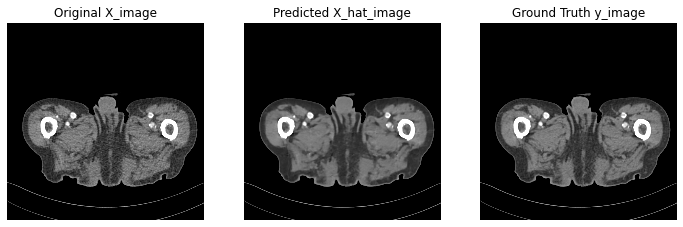

In [71]:
# 1. 가장 좋은 값 가져오기
X_test,y_test,X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [72]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'best')

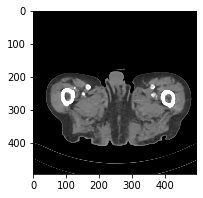

In [73]:
# 불러오기

import numpy as np

s = 'best'
X_test = np.load(f'X_hat_image{s}.npy')

plt.imshow(X_test, cmap='gray', vmin=-200, vmax=300)

### 2. worst

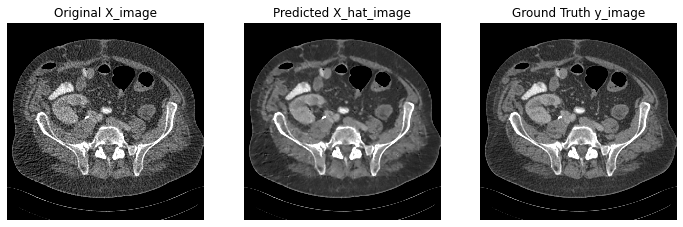

In [75]:
# 2. 가장 나쁜 값 가져오기
X_test,y_test,X_hat = worst

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [76]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'worst')

### 3. 랜덤

In [80]:
import glob
# 3. 랜덤선택

i,j = 0,0
X_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
y_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]

X_image, y_image = normlize(X_dir), normlize(y_dir)
X_patches = extract_patches(torch.from_numpy(X_image))
X_hat = model(X_patches.cuda())

X_image.shape, y_image.shape, X_hat.shape

((1, 512, 512), (1, 512, 512), torch.Size([81, 1, 55, 55]))

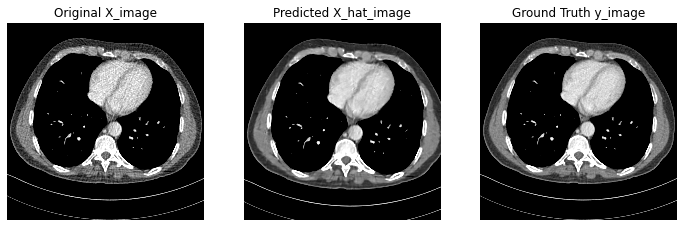

In [82]:
# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(rescale(np.squeeze(reconstruct_image(X_hat.detach().cpu()))), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [84]:
!pwd

/root/attention_channel


In [85]:
def recreat(X_dir):

    # X_patches
    X_img = normlize(X_dir)
    X_patches = extract_patches(torch.from_numpy(X_img))
    # X_hat
    X_hat = model(X_patches.cuda())

    return reconstruct_image(X_hat.detach().cpu())

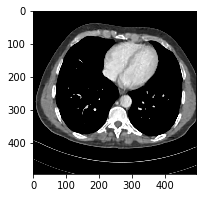

In [86]:
plt.imshow(rescale(np.squeeze(recreat(X_dir))), cmap='gray', vmin=-200, vmax=300)

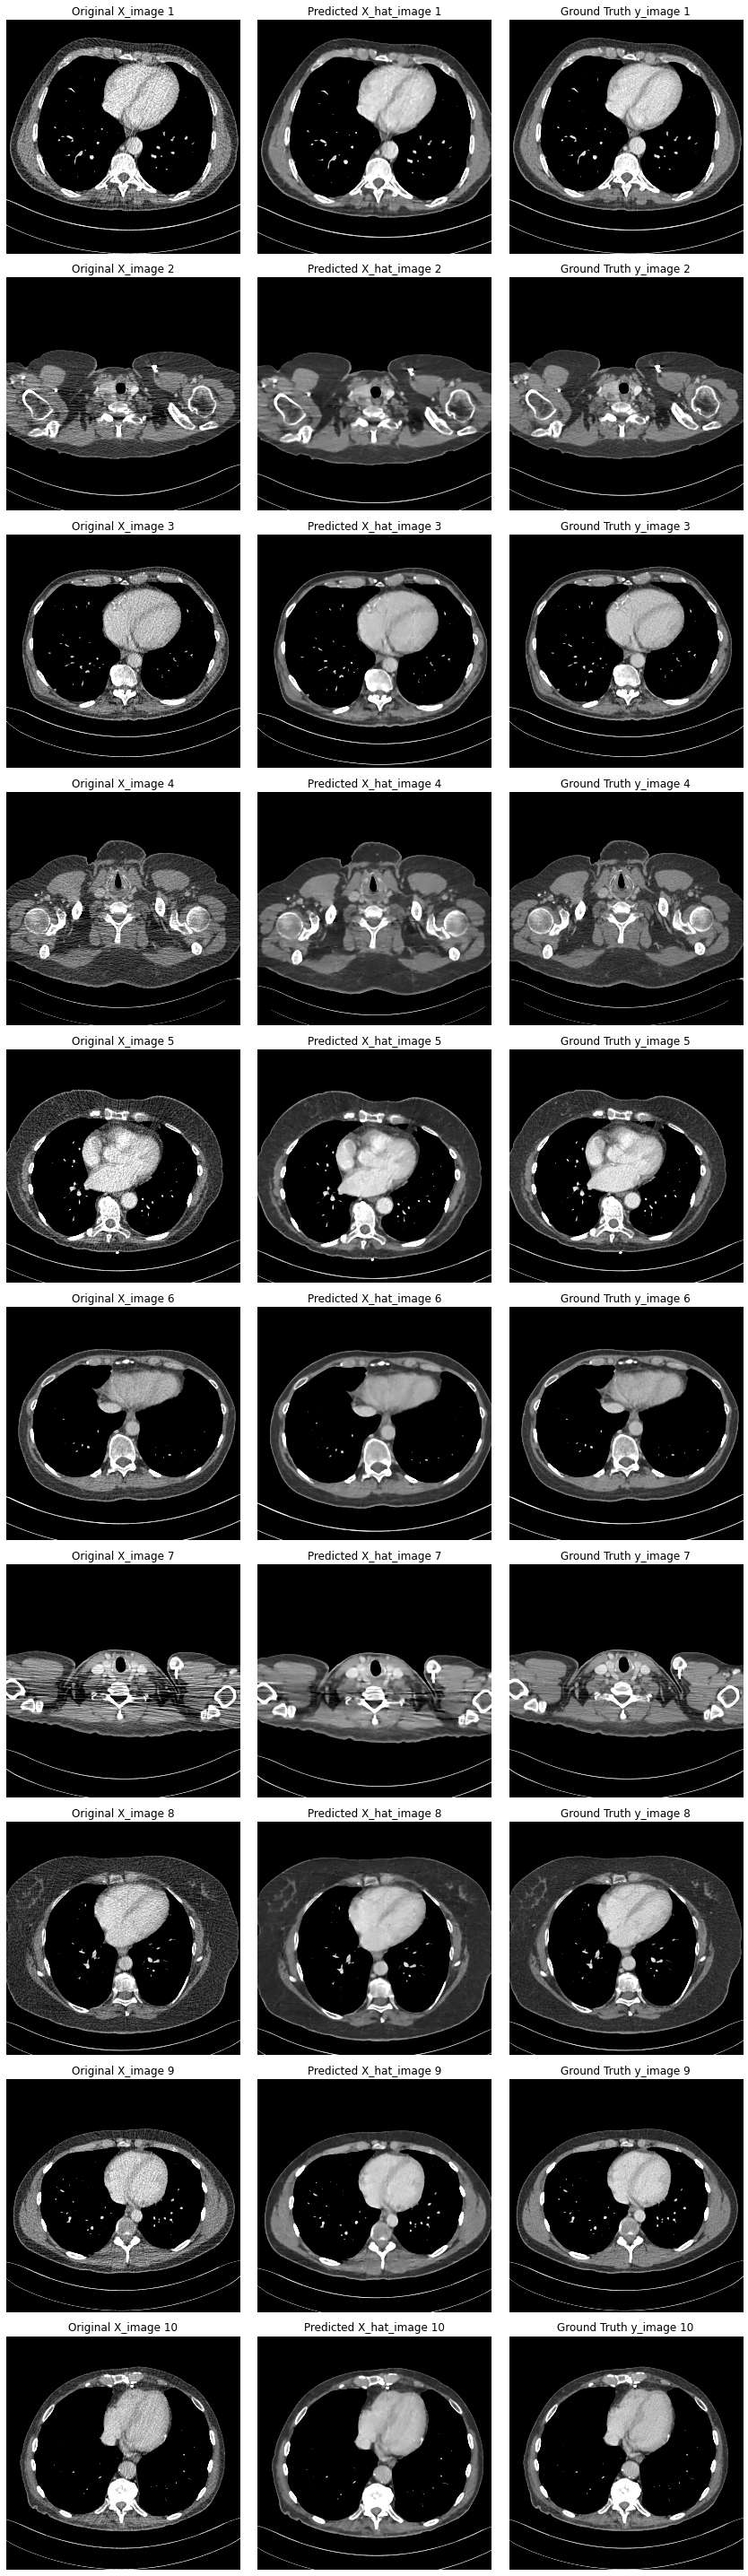

In [87]:
import matplotlib.pyplot as plt
import numpy as np

i, n = 0, 10
L = L_list[i]

# 전체 이미지 배열을 생성
fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    X_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
    y_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]
    X_image, y_image = normlize(X_dir), normlize(y_dir)
    X_patches = extract_patches(torch.from_numpy(X_image))
    reconstructed_image = recreat(X_dir)

    # X_image 표시
    axes[i, 0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 0].set_title(f"Original X_image {i+1}")
    axes[i, 0].axis('off')

    # X_hat_image 표시
    axes[i, 1].imshow(rescale(np.squeeze(reconstructed_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 1].set_title(f"Predicted X_hat_image {i+1}")
    axes[i, 1].axis('off')

    # y_image 표시
    axes[i, 2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 2].set_title(f"Ground Truth y_image {i+1}")
    axes[i, 2].axis('off')

# 모든 이미지 저장
plt.tight_layout()
plt.savefig("comparison_images.png", format="png")  # 한번에 저장
plt.show()  # 모든 이미지 표시

# attention 확인

In [88]:
!pwd

/root/attention_channel


In [89]:
%cd {root}/attention_channel

/root/attention_channel


In [90]:
# 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithChannelAttention().to(device)

# 저장된 가중치 로드
model.load_state_dict(torch.load('red_cnn_C_A.pth'))
model.eval()

RedCNNWithChannelAttention(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (attention2): SEBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=96, out_features=6, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=6, out_features=96, bias=False)
      (3): Sigmoid()
    )
  )
  (attention3): SEBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=96, out_features=6, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=6, out_features=96, bias=False)
      (3): Sigmoid()
    )
  )
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 9

## best / worst 이미지의 attention 확인

### 1. best

In [91]:
X_test,y_test,X_hat = best
X_test.shape

torch.Size([81, 1, 55, 55])

In [92]:
X_test.to(device)
output = model(X_test)

In [93]:
# Forward Pass
output = model(X_test)

model.attention2.last_attention.shape

torch.Size([81, 96, 1, 1])

In [94]:
import numpy as np

# Attention Weight 가져오기 (예: 첫 번째 SEBlock)
attention_weights2 = model.attention2.last_attention.squeeze().cpu().detach().numpy()  # [81, 96]
attention_weights3 = model.attention3.last_attention.squeeze().cpu().detach().numpy()

# 배치 차원에서 평균 계산
mean_attention_weights2 = np.mean(attention_weights2, axis=0)  # [96]
mean_attention_weights3 = np.mean(attention_weights3, axis=0)  # [96]

mean_attention_weights2.shape, mean_attention_weights3.shape

((96,), (96,))

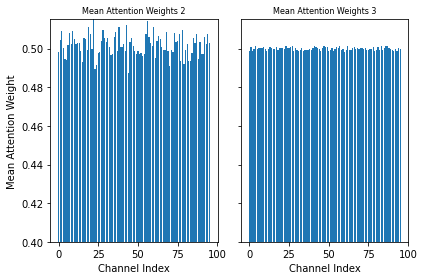

In [95]:
# 배치 차원에서 평균 계산
mean_attention_weights2 = np.mean(attention_weights2, axis=0)  # [96]
mean_attention_weights3 = np.mean(attention_weights3, axis=0)  # [96]

# y축 최소값 설정
y_min = 0.4  # 변경 가능

# y축 최대값 계산 (공통 최대값)
y_max = max(mean_attention_weights2.max(), mean_attention_weights3.max())

# Subplot 설정
fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)

# 첫 번째 subplot
axes[0].bar(range(len(mean_attention_weights2)), mean_attention_weights2)
axes[0].set_title("Mean Attention Weights 2", fontsize=8)
axes[0].set_xlabel("Channel Index")
axes[0].set_ylabel("Mean Attention Weight")
axes[0].set_ylim(y_min, y_max)  # 공통 최대값 사용

# 두 번째 subplot
axes[1].bar(range(len(mean_attention_weights3)), mean_attention_weights3)
axes[1].set_title("Mean Attention Weights 3", fontsize=8)
axes[1].set_xlabel("Channel Index")
axes[1].set_ylim(y_min, y_max)  # 공통 최대값 사용

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()


In [96]:
from decimal import Decimal

# attention2의 mean과 sd 계산
mean2 = Decimal(str(np.mean(mean_attention_weights2))).quantize(Decimal('0.001'))
sd2 = Decimal(str(np.sqrt(np.var(mean_attention_weights2)))).quantize(Decimal('0.001'))

# attention3의 mean과 sd 계산
mean3 = Decimal(str(np.mean(mean_attention_weights3))).quantize(Decimal('0.001'))
sd3 = Decimal(str(np.sqrt(np.var(mean_attention_weights3)))).quantize(Decimal('0.001'))

# 출력
print(f"Attention 2 - mean: {mean2}, sd: {sd2}")
print(f"Attention 3 - mean: {mean3}, sd: {sd3}")

Attention 2 - mean: 0.502, sd: 0.006
Attention 3 - mean: 0.500, sd: 0.001


### 2. worst

In [97]:
X_test,y_test,X_hat = worst
X_test.shape

torch.Size([81, 1, 55, 55])

In [98]:
X_test.to(device)
output = model(X_test)

In [99]:
# Forward Pass
output = model(X_test)

model.attention2.last_attention.shape

torch.Size([81, 96, 1, 1])

In [100]:
import numpy as np

# Attention Weight 가져오기 (예: 첫 번째 SEBlock)
attention_weights2 = model.attention2.last_attention.squeeze().cpu().detach().numpy()  # [81, 96]
attention_weights3 = model.attention3.last_attention.squeeze().cpu().detach().numpy()

# 배치 차원에서 평균 계산
mean_attention_weights2 = np.mean(attention_weights2, axis=0)  # [96]
mean_attention_weights3 = np.mean(attention_weights3, axis=0)  # [96]

mean_attention_weights2.shape, mean_attention_weights3.shape

((96,), (96,))

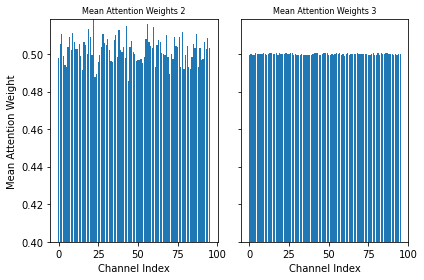

In [101]:
# 배치 차원에서 평균 계산
mean_attention_weights2 = np.mean(attention_weights2, axis=0)  # [96]
mean_attention_weights3 = np.mean(attention_weights3, axis=0)  # [96]

# y축 최소값 설정
y_min = 0.4  # 변경 가능

# y축 최대값 계산 (공통 최대값)
y_max = max(mean_attention_weights2.max(), mean_attention_weights3.max())

# Subplot 설정
fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)

# 첫 번째 subplot
axes[0].bar(range(len(mean_attention_weights2)), mean_attention_weights2)
axes[0].set_title("Mean Attention Weights 2", fontsize=8)
axes[0].set_xlabel("Channel Index")
axes[0].set_ylabel("Mean Attention Weight")
axes[0].set_ylim(y_min, y_max)  # 공통 최대값 사용

# 두 번째 subplot
axes[1].bar(range(len(mean_attention_weights3)), mean_attention_weights3)
axes[1].set_title("Mean Attention Weights 3", fontsize=8)
axes[1].set_xlabel("Channel Index")
axes[1].set_ylim(y_min, y_max)  # 공통 최대값 사용

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

In [102]:
from decimal import Decimal

# attention2의 mean과 sd 계산
mean2 = Decimal(str(np.mean(mean_attention_weights2))).quantize(Decimal('0.001'))
sd2 = Decimal(str(np.sqrt(np.var(mean_attention_weights2)))).quantize(Decimal('0.001'))

# attention3의 mean과 sd 계산
mean3 = Decimal(str(np.mean(mean_attention_weights3))).quantize(Decimal('0.001'))
sd3 = Decimal(str(np.sqrt(np.var(mean_attention_weights3)))).quantize(Decimal('0.001'))

# 출력
print(f"Attention 2 - mean: {mean2}, sd: {sd2}")
print(f"Attention 3 - mean: {mean3}, sd: {sd3}")

Attention 2 - mean: 0.502, sd: 0.007
Attention 3 - mean: 0.500, sd: 0.000


## 결론
잘나올수록 attention이 마지막 layer에서 더 차등이 크다. 그러니까 마지막 layer에서 attention이 더 효과가 있을수록 좋은 성능을 보인 것이다.

# attention모델2; Spatial Attention

In [103]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2 # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x):
        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True) # Average pooling
        max_out, _ = torch.max(x, dim=1, keepdim=True) # Max pooling
        combined = torch.cat([avg_out, max_out], dim=1) # 채널 차원에서 결합
        # 2D Convolution 적용
        attention = self.sigmoid(self.conv(combined)) # [B, 1, H, W]
        self.last_attention = attention  # Attention 값을 저장
        return x * attention

## SpatialAttention 살펴보기

In [104]:
# 입력 텐서: [batch, channels, height, width]
x = torch.rand(16, 64, 32, 32)  # Batch size=16, Channels=64, Height=32, Width=32

# Spatial Attention 적용
spatial_attention = SpatialAttention(kernel_size=7)
output = spatial_attention(x)

print(f"Input shape: {x.shape}")        # [16, 64, 32, 32]
print(f"Output shape: {output.shape}")  # [16, 64, 32, 32]


Input shape: torch.Size([16, 64, 32, 32])
Output shape: torch.Size([16, 64, 32, 32])


In [225]:
X_train.shape

torch.Size([16, 1, 55, 55])

In [ ]:
conv_layer = nn.Conv2d(1, 96, 5, 1, 0)
conv_layer(X_train).shape

torch.Size([16, 96, 51, 51])

In [ ]:
conv_v = conv_layer(X_train)
x = conv_v
avg_out = torch.mean(x, dim=1, keepdim=True)  # Average pooling
max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max pooling
combined = torch.cat([avg_out, max_out], dim=1)
conv_v.shape, avg_out.shape, max_out.shape, combined.shape

(torch.Size([16, 96, 51, 51]),
 torch.Size([16, 1, 51, 51]),
 torch.Size([16, 1, 51, 51]),
 torch.Size([16, 2, 51, 51]))

In [ ]:
padding = (7 - 1) // 2  # 동일한 크기를 유지하기 위한 패딩
conv_layer2 = nn.Conv2d(2, 1, kernel_size=7, padding=padding, bias=False)

conv_layer2(combined).shape

torch.Size([16, 1, 51, 51])

In [ ]:
sigmoid = nn.Sigmoid()
output = sigmoid(conv_layer2(combined))
output.shape

torch.Size([16, 1, 51, 51])

In [ ]:
output[0].shape

torch.Size([1, 51, 51])

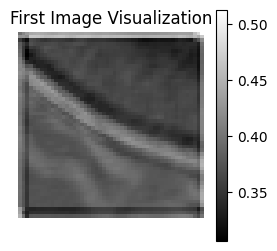

In [ ]:
import matplotlib.pyplot as plt

# Output 텐서 (torch.Size([16, 1, 51, 51]))
# 예: output 텐서가 존재한다고 가정
first_image = output[0, 0, :, :]  # 첫 번째 배치의 첫 번째 채널 선택

# 텐서를 NumPy 배열로 변환
first_image_np = first_image.detach().cpu().numpy()  # GPU 텐서일 경우 .cpu() 사용

# 시각화
plt.imshow(first_image_np, cmap='gray')
plt.colorbar()
plt.title("First Image Visualization")
plt.axis('off')
plt.show()

## 모델구현

2개의 attention을 앞단의 중간과 마지막 부분에 각각 설치

In [105]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [106]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention()
        self.spatial_attention5 = SpatialAttention()

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [107]:
model = RedCNNWithSpatialAttention().to(device)
model


RedCNNWithSpatialAttention(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (spatial_attention3): SpatialAttention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (spatial_attention5): SpatialAttention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), st

In [108]:
%cd {root}

import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

/root


<module 'utils.train_eval_util' from '/root/utils/train_eval_util.py'>

In [109]:
import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

In [110]:
import torch
from tqdm import tqdm

interval = 1000

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0.0  # ✅ 초기화

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item() * X.size(0)  # ✅ 배치별 손실 계산
        total_loss += batch_loss  # ✅ 모든 배치 손실 누적
        running_loss += batch_loss  # interval 내 손실 누적

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)  # ✅ 평균 손실 반환

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0.0  # ✅ 초기화

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            batch_loss = loss.item() * X.size(0)  # ✅ 배치별 손실 계산
            total_loss += batch_loss  # ✅ 모든 배치 손실 누적
            running_loss += batch_loss  # interval 내 손실 누적

            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                running_loss = 0.0
                tqdm.write(f'val loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)  # ✅ 평균 손실 반환


# 학습

In [111]:
!pwd

/root


In [112]:
%cd {root}/attention_spatial

/root/attention_spatial


In [113]:
epochs = 1 # 각 epoch마다 train(20분), valid(2분)이 소요된다.
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + 'red_cnn_S_A' + ".pth")
    if (early_stopping(valid_loss)):
        break

Epoch 0 - Training:   2%|▏         | 1012/57701 [00:11<16:14, 58.17it/s]

train loss : 0.07219267565011978


Epoch 0 - Training:   3%|▎         | 2016/57701 [00:22<09:10, 101.12it/s]

train loss : 0.055191328508779405


Epoch 0 - Training:   5%|▌         | 3010/57701 [00:32<09:45, 93.33it/s] 

train loss : 0.05149499044753611


Epoch 0 - Training:   7%|▋         | 4012/57701 [00:43<09:46, 91.59it/s] 

train loss : 0.04842379120178521


Epoch 0 - Training:   9%|▊         | 5014/57701 [00:54<09:39, 90.92it/s]

train loss : 0.04745085000246763


Epoch 0 - Training:  10%|█         | 6016/57701 [01:05<09:06, 94.54it/s] 

train loss : 0.0471585577763617


Epoch 0 - Training:  12%|█▏        | 7014/57701 [01:19<08:46, 96.31it/s]

train loss : 0.04518282747641206


Epoch 0 - Training:  14%|█▍        | 8013/57701 [01:30<08:31, 97.16it/s]

train loss : 0.04469079544395208


Epoch 0 - Training:  16%|█▌        | 9011/57701 [01:40<08:09, 99.46it/s] 

train loss : 0.04274624328687787


Epoch 0 - Training:  17%|█▋        | 10018/57701 [01:51<08:11, 97.08it/s]

train loss : 0.0428460353910923


Epoch 0 - Training:  19%|█▉        | 11010/57701 [02:02<08:24, 92.49it/s] 

train loss : 0.042478913452476265


Epoch 0 - Training:  21%|██        | 12014/57701 [02:12<08:09, 93.33it/s] 

train loss : 0.04220463662408292


Epoch 0 - Training:  23%|██▎       | 13011/57701 [02:23<08:01, 92.75it/s] 

train loss : 0.04171240404434502


Epoch 0 - Training:  24%|██▍       | 14012/57701 [02:33<07:44, 94.15it/s] 

train loss : 0.041378427421674135


Epoch 0 - Training:  26%|██▌       | 15012/57701 [02:47<10:55, 65.09it/s] 

train loss : 0.0410993214379996


Epoch 0 - Training:  28%|██▊       | 16014/57701 [02:59<07:07, 97.58it/s] 

train loss : 0.04075048804469407


Epoch 0 - Training:  29%|██▉       | 17015/57701 [03:09<07:04, 95.94it/s] 

train loss : 0.04037805308401585


Epoch 0 - Training:  31%|███       | 18018/57701 [03:24<06:52, 96.27it/s] 

train loss : 0.0397412627749145


Epoch 0 - Training:  33%|███▎      | 19011/57701 [03:34<06:44, 95.71it/s] 

train loss : 0.03985793060623109


Epoch 0 - Training:  35%|███▍      | 20013/57701 [03:45<06:32, 95.99it/s] 

train loss : 0.039624935047701


Epoch 0 - Training:  36%|███▋      | 21015/57701 [03:55<06:20, 96.49it/s] 

train loss : 0.039268679287284614


Epoch 0 - Training:  38%|███▊      | 22013/57701 [04:05<05:51, 101.52it/s]

train loss : 0.03966992112249136


Epoch 0 - Training:  40%|███▉      | 23009/57701 [04:16<06:10, 93.69it/s] 

train loss : 0.03906789260357618


Epoch 0 - Training:  42%|████▏     | 24018/57701 [04:26<05:41, 98.53it/s] 

train loss : 0.03940087456814945


Epoch 0 - Training:  43%|████▎     | 25016/57701 [04:37<06:07, 88.98it/s] 

train loss : 0.038505158819258214


Epoch 0 - Training:  45%|████▌     | 26015/57701 [04:47<05:42, 92.40it/s] 

train loss : 0.03824831074289978


Epoch 0 - Training:  47%|████▋     | 27014/57701 [04:58<05:35, 91.43it/s] 

train loss : 0.038782507816329595


Epoch 0 - Training:  49%|████▊     | 28009/57701 [05:09<05:23, 91.69it/s] 

train loss : 0.03864754093624651


Epoch 0 - Training:  50%|█████     | 29009/57701 [05:19<05:05, 93.92it/s] 

train loss : 0.03854621572420001


Epoch 0 - Training:  52%|█████▏    | 30019/57701 [05:30<04:53, 94.42it/s] 

train loss : 0.03797404715232551


Epoch 0 - Training:  54%|█████▎    | 31012/57701 [05:40<04:48, 92.40it/s] 

train loss : 0.037983963811770084


Epoch 0 - Training:  55%|█████▌    | 32011/57701 [05:50<03:58, 107.54it/s]

train loss : 0.03805463209748268


Epoch 0 - Training:  57%|█████▋    | 33013/57701 [06:00<04:18, 95.52it/s] 

train loss : 0.03822419155016542


Epoch 0 - Training:  59%|█████▉    | 34017/57701 [06:11<04:11, 94.16it/s] 

train loss : 0.03849314983561635


Epoch 0 - Training:  61%|██████    | 35014/57701 [06:21<04:04, 92.67it/s] 

train loss : 0.03798537066020072


Epoch 0 - Training:  62%|██████▏   | 36015/57701 [06:31<03:51, 93.81it/s] 

train loss : 0.03765136326290667


Epoch 0 - Training:  64%|██████▍   | 37020/57701 [06:41<03:12, 107.33it/s]

train loss : 0.03710756365954876


Epoch 0 - Training:  66%|██████▌   | 38014/57701 [06:53<05:16, 62.18it/s] 

train loss : 0.03760313365980983


Epoch 0 - Training:  68%|██████▊   | 39014/57701 [07:06<03:08, 99.00it/s] 

train loss : 0.03764037351123989


Epoch 0 - Training:  69%|██████▉   | 40015/57701 [07:16<03:05, 95.40it/s] 

train loss : 0.03768984484858811


Epoch 0 - Training:  71%|███████   | 41015/57701 [07:27<02:53, 96.21it/s] 

train loss : 0.037476430520415306


Epoch 0 - Training:  73%|███████▎  | 42014/57701 [07:37<02:46, 94.11it/s] 

train loss : 0.03738299698382616


Epoch 0 - Training:  75%|███████▍  | 43009/57701 [07:47<02:30, 97.53it/s] 

train loss : 0.03674663911387324


Epoch 0 - Training:  76%|███████▋  | 44019/57701 [07:58<02:20, 97.19it/s] 

train loss : 0.03731523316726088


Epoch 0 - Training:  78%|███████▊  | 45015/57701 [08:08<02:09, 98.08it/s] 

train loss : 0.03725059508346021


Epoch 0 - Training:  80%|███████▉  | 46019/57701 [08:19<01:54, 101.96it/s]

train loss : 0.03686226508207619


Epoch 0 - Training:  81%|████████▏ | 47012/57701 [08:29<01:52, 95.31it/s] 

train loss : 0.03702868436649442


Epoch 0 - Training:  83%|████████▎ | 48010/57701 [08:39<01:35, 101.13it/s]

train loss : 0.03698756275698543


Epoch 0 - Training:  85%|████████▍ | 49010/57701 [08:50<01:31, 94.67it/s] 

train loss : 0.03705132138542831


Epoch 0 - Training:  87%|████████▋ | 50012/57701 [09:00<01:20, 94.94it/s] 

train loss : 0.036661710787564514


Epoch 0 - Training:  88%|████████▊ | 51018/57701 [09:11<01:13, 90.54it/s] 

train loss : 0.036418691534549


Epoch 0 - Training:  90%|█████████ | 52014/57701 [09:21<01:01, 92.21it/s] 

train loss : 0.03684760376997292


Epoch 0 - Training:  92%|█████████▏| 53021/57701 [09:32<00:45, 103.96it/s]

train loss : 0.03624631654843688


Epoch 0 - Training:  94%|█████████▎| 54014/57701 [09:42<00:38, 95.08it/s] 

train loss : 0.03665544632449746


Epoch 0 - Training:  95%|█████████▌| 55012/57701 [09:53<00:29, 89.73it/s] 

train loss : 0.03711902105435729


Epoch 0 - Training:  97%|█████████▋| 56016/57701 [10:03<00:18, 91.59it/s] 

train loss : 0.036584909424185755


Epoch 0 - Training:  99%|█████████▉| 57012/57701 [10:14<00:07, 94.97it/s] 

train loss : 0.03650359807908535


Epoch 0 - Evaluating:  22%|██▏       | 1061/4815 [00:03<00:10, 345.41it/s]

val loss : 0.04286389639787376


Epoch 0 - Evaluating:  43%|████▎     | 2060/4815 [00:06<00:08, 331.55it/s]

val loss : 0.04589764606254175


Epoch 0 - Evaluating:  64%|██████▎   | 3059/4815 [00:09<00:05, 345.05it/s]

val loss : 0.03063658647541888


Epoch 0 - Evaluating:  84%|████████▍ | 4068/4815 [00:12<00:02, 342.93it/s]

val loss : 0.03385152382403612


Epoch 0 - Evaluating: 100%|██████████| 4815/4815 [00:14<00:00, 321.85it/s]

Epoch [1/1], Train Loss: 0.0025, Valid Loss: 0.0023



/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [114]:
import pickle

data_to_save = {
    'train_loss_per_iter': train_loss_per_iter,
    'val_loss_per_iter': val_loss_per_iter,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch
}

for filename, data in data_to_save.items():
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [115]:
import pickle

filenames = [
    'train_loss_per_iter.pkl',
    'val_loss_per_iter.pkl',
    'train_loss_per_epoch.pkl',
    'val_loss_per_epoch.pkl'
]

variables = [
    'train_loss_per_iter',
    'val_loss_per_iter',
    'train_loss_per_epoch',
    'val_loss_per_epoch'
]

data_to_load = dict(zip(filenames, variables))

for filename, variable_name in data_to_load.items():
    with open(filename, 'rb') as f:
        globals()[variable_name] = pickle.load(f)

In [116]:
train_flatten, val_flatten = [item for sublist in train_loss_per_iter for item in sublist], [item for sublist in val_loss_per_iter for item in sublist]

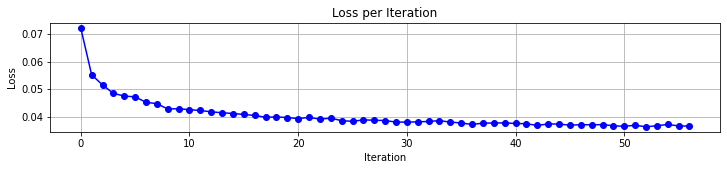

In [117]:
plt.figure(figsize=(12, 2))

# 반복 단위 손실 그래프
plt.plot(train_flatten, label='Train (per iter)', linestyle='-', marker='o', color='blue')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

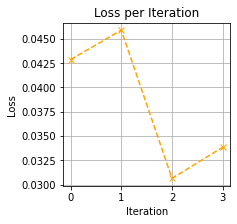

In [118]:
plt.plot(val_flatten, label='Validation (per iter)', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

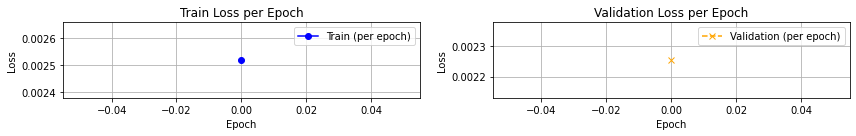

In [119]:
# 1행 2열 레이아웃 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 2))  # 그래프 크기 조정

# Train loss per epoch 그래프
axes[0].plot(train_loss_per_epoch, label='Train (per epoch)', linestyle='-', marker='o', color='blue')
axes[0].set_title("Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# Validation loss per epoch 그래프
axes[1].plot(val_loss_per_epoch, label='Validation (per epoch)', linestyle='--', marker='x', color='orange')
axes[1].set_title("Validation Loss per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

# 평가

In [120]:
!pwd

/root/attention_spatial


In [121]:
%cd {root}/attention_spatial

/root/attention_spatial


In [122]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## batch size 16

### loss 추이 관찰

In [123]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('red_cnn_S_A.pth'))

<All keys matched successfully>

In [124]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

6025

In [125]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  17%|█▋        | 1052/6025 [00:03<00:14, 346.19it/s]

train loss : 0.03750049197347835


Evaluating:  34%|███▍      | 2036/6025 [00:06<00:12, 330.28it/s]

train loss : 0.0342650890937075


Evaluating:  51%|█████     | 3058/6025 [00:09<00:08, 350.63it/s]

train loss : 0.03574764311942272


Evaluating:  67%|██████▋   | 4047/6025 [00:11<00:05, 356.87it/s]

train loss : 0.025365585000719875


Evaluating:  84%|████████▎ | 5032/6025 [00:14<00:03, 328.07it/s]

train loss : 0.024719808953581376


Evaluating: 100%|█████████▉| 5997/6025 [00:17<00:00, 332.05it/s]

train loss : 0.02259873226005584


Evaluating: 100%|██████████| 6025/6025 [00:18<00:00, 327.09it/s]


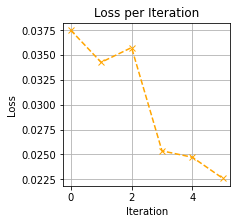

In [126]:
plt.plot(loss_list, label='Test', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

### 16개 개별비교

In [127]:
def visualize_patches_total(X, y, X_hat):

    fig, axes = plt.subplots(3, 16, figsize=(32, 6))  # 3행 16열로 설정
    fig.suptitle("Patches", fontsize=12, y=1.05)  # 전체 제목 추가

    for i in range(X.shape[0]):  # 16개의 이미지만큼 반복
        # X 데이터 시각화
        axes[0, i].imshow(X[i], cmap='gray', vmin=-200, vmax=300)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"X {i+1}", fontsize=12)

        # y 데이터 시각화
        axes[1, i].imshow(y[i], cmap='gray', vmin=-200, vmax=300)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"y {i+1}", fontsize=12)

        # X_hat 데이터 시각화
        axes[2, i].imshow(X_hat[i], cmap='gray', vmin=-200, vmax=300)
        axes[2, i].axis('off')
        axes[2, i].set_title(f"X_hat {i+1}", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # 제목 위치 조정
    plt.show()


In [128]:
# 1. 랜덤비교

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
test_iter = iter(test_loader)
len(test_iter)

6025

In [129]:
idx = 400 # 1~6025 여기 안에서 선택
for i in range(idx):
    X_test, y_test = next(test_iter)

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(model(X_test.cuda()).cpu().detach()).numpy() * 500 - 500

In [130]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

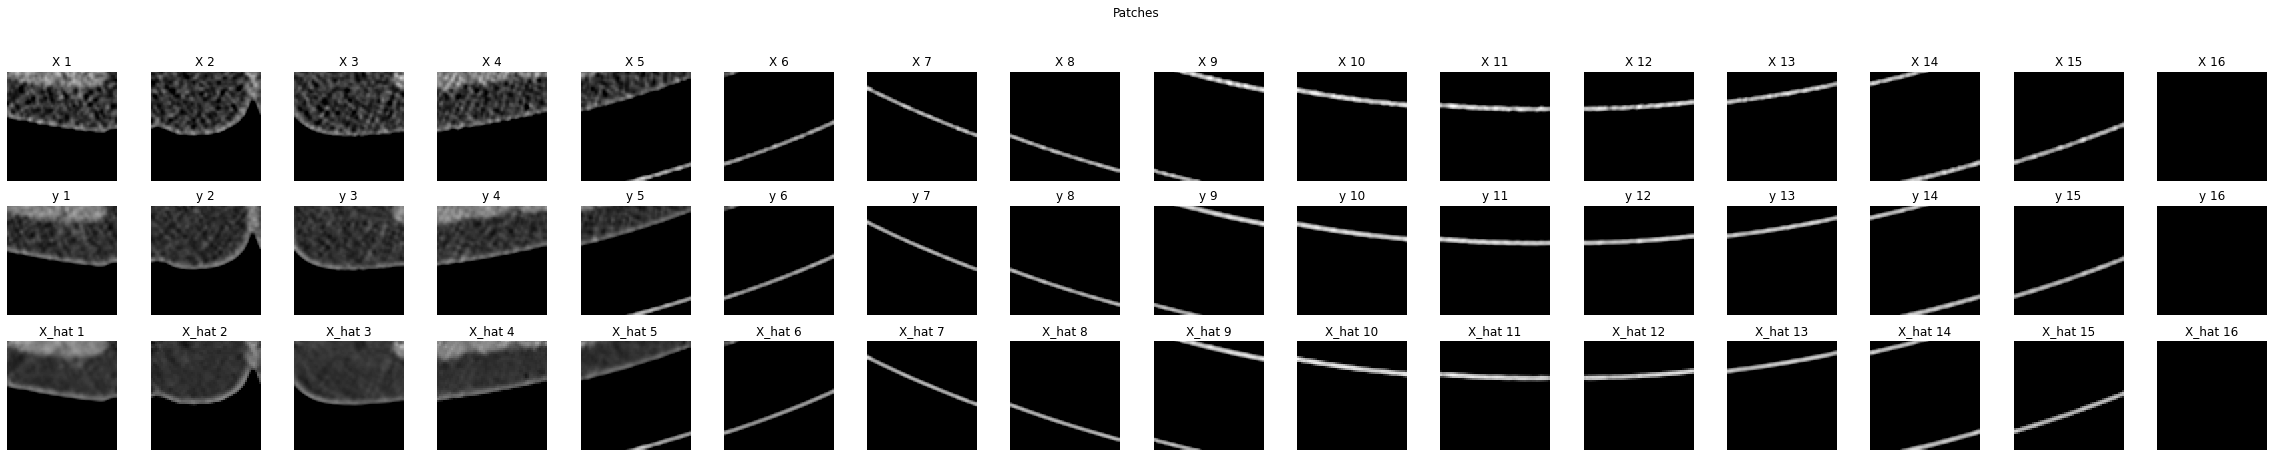

In [131]:
visualize_patches_total(X, y, X_hat)

In [132]:
# 2. 가장 loss가 낮은 값 확인

X_test,y_test,X_hat = best

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(X_hat.cpu().numpy()) * 500 - 500

In [133]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

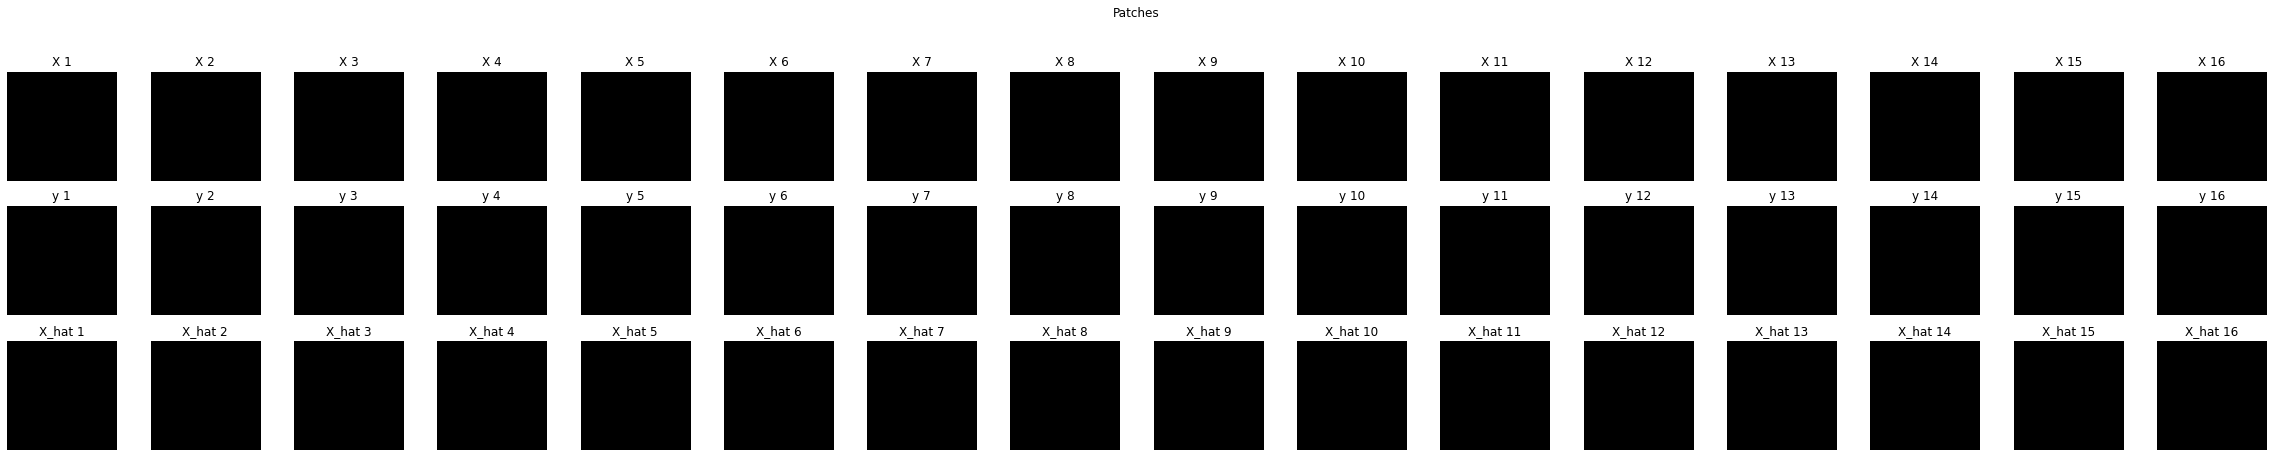

In [134]:
visualize_patches_total(X, y, X_hat)

In [135]:
# 3. 가장 loss가 높은 값 확인

X_test,y_test,X_hat = worst

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(X_hat.cpu().numpy()) * 500 - 500

In [136]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

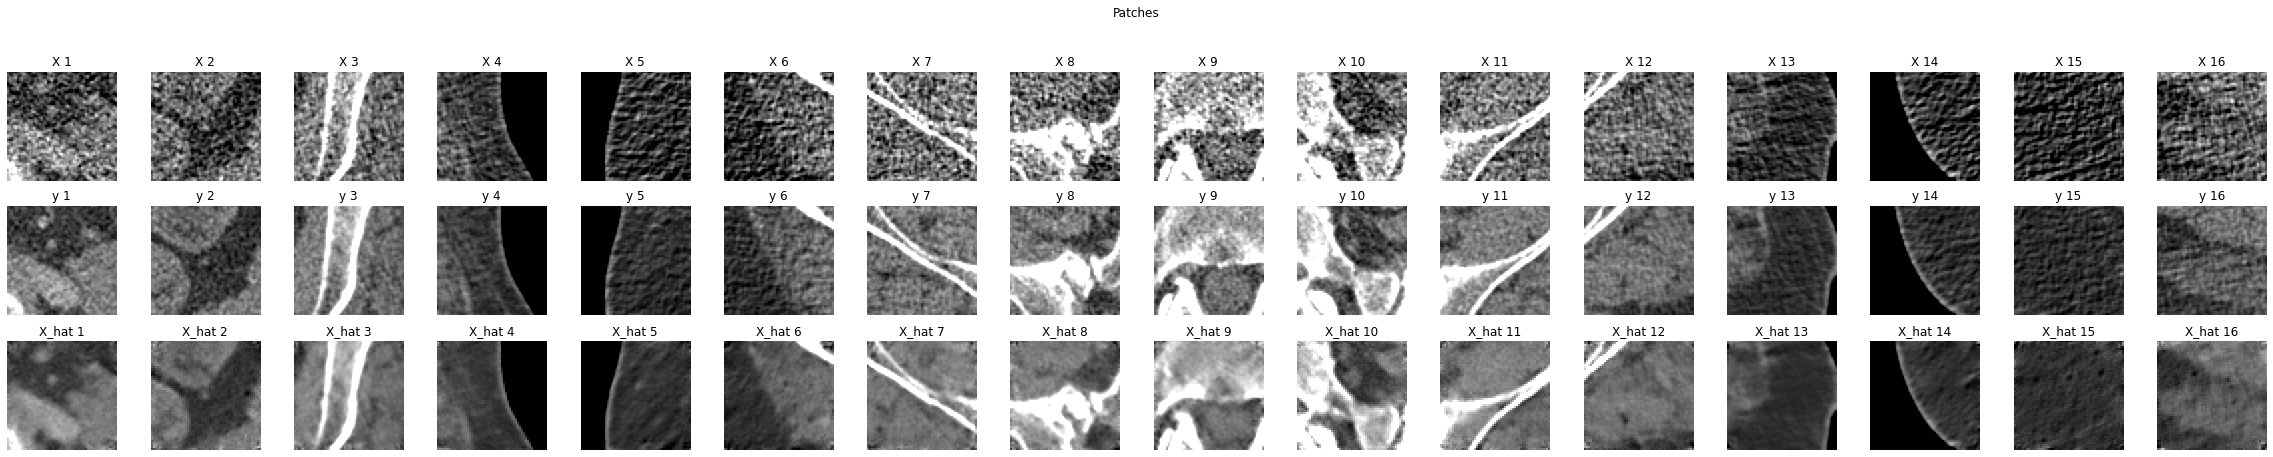

In [137]:
visualize_patches_total(X, y, X_hat)

## batch size = 81

In [138]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('red_cnn_S_A.pth'))

<All keys matched successfully>

In [139]:
test_loader = DataLoader(test_dataset, batch_size=81, shuffle=False, num_workers=4, pin_memory=True)
len(test_loader)

1190

In [140]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  85%|████████▍ | 1007/1190 [00:15<00:02, 64.70it/s]

train loss : 0.1593145631100051


Evaluating: 100%|██████████| 1190/1190 [00:19<00:00, 61.30it/s]


### 함수정의

In [141]:
def reconstruct_image(prediction, num_patches_per_row=9, patch_size=55):
    # prediction: (81, 1, 55, 55) 크기의 torch 텐서
    num_patches = prediction.shape[0]  # 81개의 패치
    assert prediction.shape == (81, 1, 55, 55) # "패치의 크기가 올바르지 않습니다."

    # 최종적으로 1x495x495 크기의 이미지를 만들기 위한 초기화
    final_image = torch.zeros(1, num_patches_per_row * patch_size, num_patches_per_row * patch_size)

    # 9x9 배열로 패치 붙이기
    for i in range(num_patches):
        row = i // num_patches_per_row  # 현재 패치의 행 번호
        col = i % num_patches_per_row   # 현재 패치의 열 번호

        # 패치를 해당 위치에 붙이기
        final_image[:,
                    row * patch_size:(row + 1) * patch_size,
                    col * patch_size:(col + 1) * patch_size] = prediction[i, 0]

    return final_image

In [142]:
def extract_patches(img, patch_size=55, interval=55):
    patches = []
    _, height, width = img.shape
    for y in range(0, height - patch_size + 1, interval):
        for x in range(0, width - patch_size + 1, interval):
            patch = img[:, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    patches = torch.stack(patches)  # 리스트를 텐서로 변환
    return patches  # 반환 형태는 patch 수 x 1 x 55 x 55

In [143]:
def rescale(img):
    return img*500-500 # -1000부터 2000의 값으로 다시 변환

In [144]:
def trans_img(X):
    return rescale(np.squeeze(reconstruct_image(X)))

In [145]:
X_test,y_test,X_hat = best
trans_img(X_test).min(), trans_img(X_test).max()

(tensor(-1024.), tensor(1862.))

In [146]:
!pwd

/root/attention_spatial


In [147]:
def save_img(X_test, X_hat, y_test, s):
    # X_test 저장
    numpy_X_test = trans_img(X_test).numpy()
    np.save(f'X_test_image{s}.npy', numpy_X_test)

    # X_hat 저장
    numpy_X_hat = trans_img(X_hat).numpy()
    np.save(f'X_hat_image{s}.npy', numpy_X_hat)

    # y_test 저장
    numpy_y_test = trans_img(y_test).numpy()
    np.save(f'y_test_image{s}.npy', numpy_y_test)

### 1. best

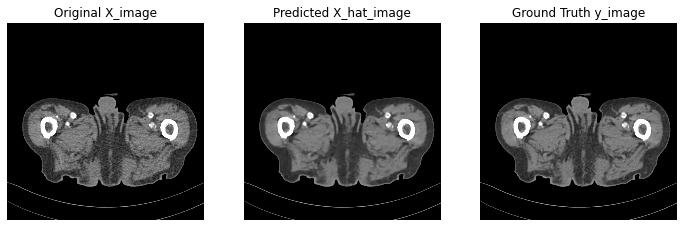

In [148]:
# 1. 가장 좋은 값 가져오기
X_test,y_test,X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [149]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'best')

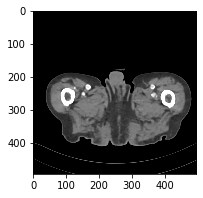

In [150]:
# 불러오기

import numpy as np

s = 'best'
X_test = np.load(f'X_hat_image{s}.npy')

plt.imshow(X_test, cmap='gray', vmin=-200, vmax=300)

### 2. worst

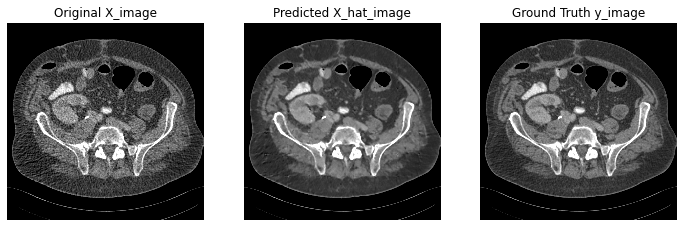

In [151]:
# 2. 가장 나쁜 값 가져오기
X_test,y_test,X_hat = worst

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [152]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'worst')

### 3. 랜덤

In [153]:
import glob
# 3. 랜덤선택

i,j = 0,0
X_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
y_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]

X_image, y_image = normlize(X_dir), normlize(y_dir)
X_patches = extract_patches(torch.from_numpy(X_image))
X_hat = model(X_patches.cuda())

X_image.shape, y_image.shape, X_hat.shape

((1, 512, 512), (1, 512, 512), torch.Size([81, 1, 55, 55]))

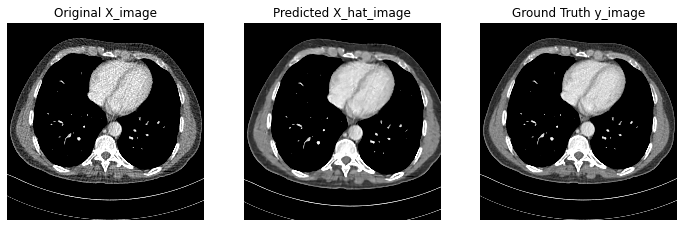

In [154]:
# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(rescale(np.squeeze(reconstruct_image(X_hat.detach().cpu()))), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [155]:
!pwd

/root/attention_spatial


In [160]:
def recreat(X_dir):

    # X_patches
    X_img = normlize(X_dir)
    X_patches = extract_patches(torch.from_numpy(X_img))
    # X_hat
    X_hat = model(X_patches.cuda())

    return reconstruct_image(X_hat.detach().cpu())

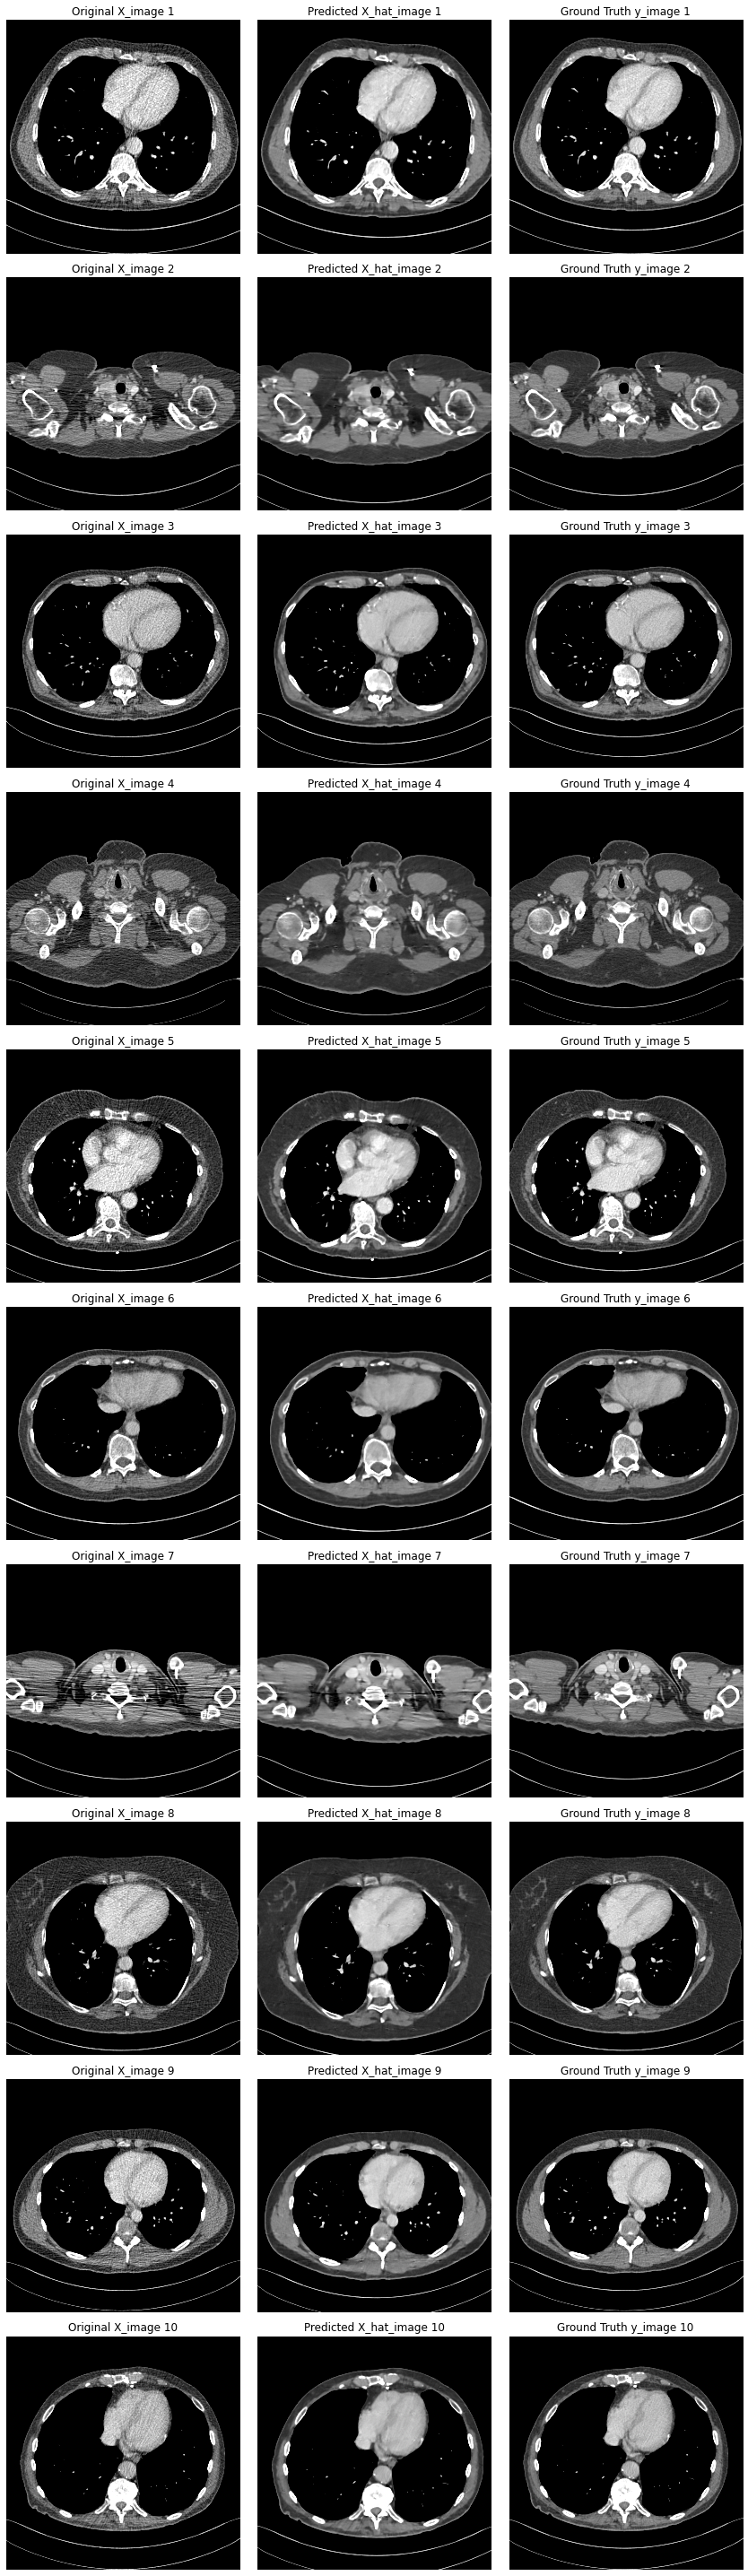

In [161]:
import matplotlib.pyplot as plt
import numpy as np

i, n = 0, 10
L = L_list[i]

# 전체 이미지 배열을 생성
fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    X_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
    y_dir = sorted(glob.glob(f'{root}/mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]
    X_image, y_image = normlize(X_dir), normlize(y_dir)
    X_patches = extract_patches(torch.from_numpy(X_image))
    reconstructed_image = recreat(X_dir)

    # X_image 표시
    axes[i, 0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 0].set_title(f"Original X_image {i+1}")
    axes[i, 0].axis('off')

    # X_hat_image 표시
    axes[i, 1].imshow(rescale(np.squeeze(reconstructed_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 1].set_title(f"Predicted X_hat_image {i+1}")
    axes[i, 1].axis('off')

    # y_image 표시
    axes[i, 2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 2].set_title(f"Ground Truth y_image {i+1}")
    axes[i, 2].axis('off')

# 모든 이미지 저장
plt.tight_layout()
plt.savefig("comparison_images.png", format="png")  # 한번에 저장
plt.show()  # 모든 이미지 표시

# attention 확인

In [162]:
# 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)

# 저장된 가중치 로드
model.load_state_dict(torch.load('red_cnn_S_A.pth'))
model.eval()

RedCNNWithSpatialAttention(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (spatial_attention3): SpatialAttention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (spatial_attention5): SpatialAttention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), st

## best / worst 이미지의 attention 확인

### 함수정의

In [163]:
def reconstruct_image(prediction, num_patches_per_row=9, patch_size=55):
    # prediction: (81, 1, 55, 55) 크기의 torch 텐서
    num_patches = prediction.shape[0]  # 81개의 패치

    # 최종적으로 1x495x495 크기의 이미지를 만들기 위한 초기화
    final_image = torch.zeros(1, num_patches_per_row * patch_size, num_patches_per_row * patch_size)

    # 9x9 배열로 패치 붙이기
    for i in range(num_patches):
        row = i // num_patches_per_row  # 현재 패치의 행 번호
        col = i % num_patches_per_row   # 현재 패치의 열 번호

        # 패치를 해당 위치에 붙이기
        final_image[:,
                    row * patch_size:(row + 1) * patch_size,
                    col * patch_size:(col + 1) * patch_size] = prediction[i, 0]

    return final_image

In [164]:
def extract_patches(img, patch_size=55, interval=55):
    patches = []
    _, height, width = img.shape
    for y in range(0, height - patch_size + 1, interval):
        for x in range(0, width - patch_size + 1, interval):
            patch = img[:, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    patches = torch.stack(patches)  # 리스트를 텐서로 변환
    return patches  # 반환 형태는 patch 수 x 1 x 55 x 55

In [165]:
def rescale(img):
    return img*500-500 # -1000부터 2000의 값으로 다시 변환

In [166]:
def trans_img(X):
    return rescale(np.squeeze(reconstruct_image(X)))

### 1. best

In [167]:
X_test,y_test,X_hat = best
X_test.shape

torch.Size([81, 1, 55, 55])

In [168]:
X_test.to(device)
output = model(X_test)

In [169]:
# Forward Pass
output = model(X_test)

att_matrix3 = model.spatial_attention3.last_attention
att_matrix5 = model.spatial_attention5.last_attention

att_matrix3.shape, att_matrix5.shape

(torch.Size([81, 1, 43, 43]), torch.Size([81, 1, 35, 35]))

In [170]:
att_matrix3.max(), att_matrix3.min()

(tensor(0.9811, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.5464, device='cuda:0', grad_fn=<MinBackward1>))

In [171]:
att_matrix5.max(), att_matrix5.min()

(tensor(0.5540, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.4060, device='cuda:0', grad_fn=<MinBackward1>))

In [172]:
from decimal import Decimal

# attention2의 mean과 sd 계산
mean3 = Decimal(str(np.mean(att_matrix3.cpu().detach().numpy()))).quantize(Decimal('0.001'))
sd3 = Decimal(str(np.sqrt(np.var(att_matrix3.cpu().detach().numpy())))).quantize(Decimal('0.001'))

# attention3의 mean과 sd 계산
mean5 = Decimal(str(np.mean(att_matrix5.cpu().detach().numpy()))).quantize(Decimal('0.001'))
sd5 = Decimal(str(np.sqrt(np.var(att_matrix5.cpu().detach().numpy())))).quantize(Decimal('0.001'))

# 출력
print(f"Attention 2 - mean: {mean3}, sd: {sd3}")
print(f"Attention 3 - mean: {mean5}, sd: {sd5}")

Attention 2 - mean: 0.732, sd: 0.086
Attention 3 - mean: 0.494, sd: 0.007


In [173]:
att_matrix3_img = reconstruct_image(prediction=att_matrix3, patch_size=att_matrix3.shape[-1])
att_matrix5_img = reconstruct_image(prediction=att_matrix5, patch_size=att_matrix5.shape[-1])

att_matrix3_img.shape, att_matrix5_img.shape

(torch.Size([1, 387, 387]), torch.Size([1, 315, 315]))

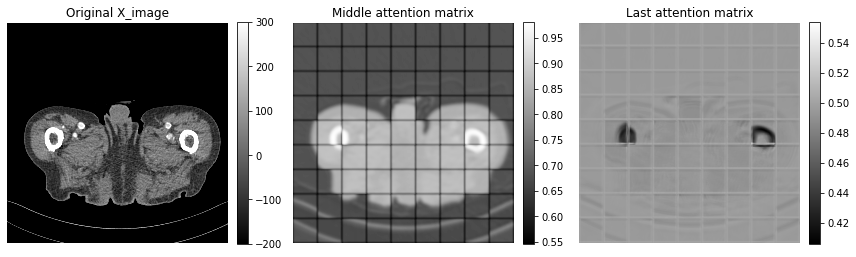

In [174]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 첫 번째 이미지
im0 = axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# 두 번째 이미지
im1 = axes[1].imshow(np.squeeze(att_matrix3_img.detach().cpu().numpy()), cmap='gray')
axes[1].set_title("Middle attention matrix")
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# 세 번째 이미지
im2 = axes[2].imshow(np.squeeze(att_matrix5_img.detach().cpu().numpy()), cmap='gray')
axes[2].set_title("Last attention matrix")
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### 2. worst

In [175]:
X_test,y_test,X_hat = worst
X_test.shape

torch.Size([81, 1, 55, 55])

In [176]:
X_test.to(device)
output = model(X_test)

In [177]:
# Forward Pass
output = model(X_test)

att_matrix3 = model.spatial_attention3.last_attention
att_matrix5 = model.spatial_attention5.last_attention

att_matrix3.shape, att_matrix5.shape

(torch.Size([81, 1, 43, 43]), torch.Size([81, 1, 35, 35]))

In [178]:
from decimal import Decimal

# attention2의 mean과 sd 계산
mean3 = Decimal(str(np.mean(att_matrix3.cpu().detach().numpy()))).quantize(Decimal('0.001'))
sd3 = Decimal(str(np.sqrt(np.var(att_matrix3.cpu().detach().numpy())))).quantize(Decimal('0.001'))

# attention3의 mean과 sd 계산
mean5 = Decimal(str(np.mean(att_matrix5.cpu().detach().numpy()))).quantize(Decimal('0.001'))
sd5 = Decimal(str(np.sqrt(np.var(att_matrix5.cpu().detach().numpy())))).quantize(Decimal('0.001'))

# 출력
print(f"Attention 2 - mean: {mean3}, sd: {sd3}")
print(f"Attention 3 - mean: {mean5}, sd: {sd5}")

Attention 2 - mean: 0.776, sd: 0.082
Attention 3 - mean: 0.494, sd: 0.004


In [179]:
att_matrix3_img = reconstruct_image(prediction=att_matrix3, patch_size=att_matrix3.shape[-1])
att_matrix5_img = reconstruct_image(prediction=att_matrix5, patch_size=att_matrix5.shape[-1])

att_matrix3_img.shape, att_matrix5_img.shape

(torch.Size([1, 387, 387]), torch.Size([1, 315, 315]))

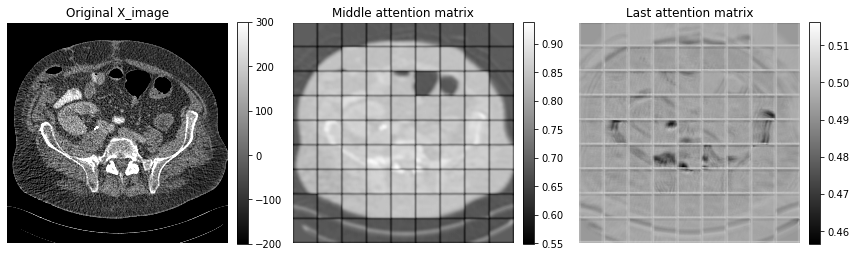

In [180]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 첫 번째 이미지
im0 = axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# 두 번째 이미지
im1 = axes[1].imshow(np.squeeze(att_matrix3_img.detach().cpu().numpy()), cmap='gray')
axes[1].set_title("Middle attention matrix")
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# 세 번째 이미지
im2 = axes[2].imshow(np.squeeze(att_matrix5_img.detach().cpu().numpy()), cmap='gray')
axes[2].set_title("Last attention matrix")
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()